# Load Data

In [91]:
dt = 1/60 # fps
delay = 0.083 # s
T = 50  # frames selected for STA

In [92]:
import datajoint as dj
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import HTMLWriter
from matplotlib.animation import FuncAnimation
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import convolve
from matplotlib.animation import HTMLWriter
from matplotlib.animation import FuncAnimation
import matplotlib.gridspec as gridspec
from scipy.interpolate import griddata
import pickle
import stimgenerate as sg
import matplotlib.patches as mpatches
import pandas as pd
import scipy.stats as stats
from scipy.integrate import simpson
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

dj.conn()
symphony = dj.VirtualModule(module_name='symphony', schema_name='sln_symphony')
NM = symphony.Experiment.ProtNaturalMovingObjectV1ep() * symphony.Experiment.ProtNaturalMovingObjectV1bp() * symphony.SpikeTrain() &'file_name="080124B"'& "source_id=3"&'motion_trajectory="natural"'
CM = symphony.Experiment.ProtNaturalMovingObjectV1ep() * symphony.Experiment.ProtNaturalMovingObjectV1bp() * symphony.SpikeTrain() &'file_name="080124B"'& "source_id=3"&'motion_trajectory="control"'
spike_indices_n = NM.fetch('spike_indices')
spike_indices_c = CM.fetch('spike_indices')
spike_indices_n = spike_indices_n.tolist()
spike_indices_c = spike_indices_c.tolist()
for i in range(len(spike_indices_n)):
    spike_indices_n[i] = np.transpose(spike_indices_n[i])
for i in range(len(spike_indices_c)):
    spike_indices_c[i] = np.transpose(spike_indices_c[i])
res_file = r"results/080124B_results.mat"
f = h5py.File(res_file)

for cell in f['results']['NaturalMovingObject'][1,:]:

    if len(f[cell]) < 63:
        continue

    trajx_n = []    
    trajy_n = []    
    trajx_c = []    
    trajy_c = []    
    # spike_indices_n = []
    # spike_indices_c = []
    
    for cx,cy,si,t in zip(f[cell]['cx'][0,:], f[cell]['cy'][0,:], f[cell]['spike_indices'][0,:], f[cell]['motion_trajectory'][0,:]):
        if "".join(np.vectorize(chr)(f[t][:]).flatten()) == 'natural':
            trajx_n.extend(f[cx][:])
            trajy_n.extend(f[cy][:])
            # spike_indices_n.append(f[si][:])
        else:
            trajx_c.extend(f[cx][:])
            trajy_c.extend(f[cy][:])
            # spike_indices_c.append(f[si][:])
    break # only use the first cell, for this example


for cell in f['results']['SpotField'][1,:]:
    trajx_SF30 = []    
    trajy_SF30 = []    
    spike_indices_SF30 = [] 
    trajx_SF15 = []    
    trajy_SF15 = []
    spike_indices_SF15 = []

    for cx,cy,si,ss in zip(f[cell]['cx'][0,:], f[cell]['cy'][0,:], f[cell]['spike_indices'][0,:], f[cell]['spot_size'][0,:]):
        if f[ss][()]==30:
            trajx_SF30.extend(f[cx][:].transpose()+15)
            trajy_SF30.extend(f[cy][:].transpose()-25)
            spike_indices_SF30.append(f[si][:])
        else:
            trajx_SF15.extend(f[cx][:].transpose()+15)
            trajy_SF15.extend(f[cy][:].transpose()-25)
            spike_indices_SF15.append(f[si][:])
    break # only use the first cell

for cell in f['results']['MovingObject'][1,:]:
    v_M = []
    direc_M = []   
    spike_indices_M = []
    center_time_shift = []
    for speed,direction,si,ct in zip(f[cell]['speed'][0,:], f[cell]['direction'][0,:], f[cell]['spike_indices'][0,:],f[cell]['center_time_shift'][0,:]):
        v_M.extend(f[speed][:])
        direc_M.extend(f[direction][:])
        spike_indices_M.append(f[si][:])
        center_time_shift.append(f[ct][:])

    break # only use the first cell


In [93]:
with open('results/spike_indices_n.pkl', 'wb') as f:
    pickle.dump(spike_indices_n, f)
with open('results/spike_indices_c.pkl', 'wb') as f:
    pickle.dump(spike_indices_c, f)
    

In [94]:

epochD = (15+15+45)/60 *10000# 1/10000 s
binsSF = np.arange(0, epochD*29, epochD) 
spikecountsSF = []
for i in range(len(spike_indices_SF15)):
    countstem, bin_edgesSF = np.histogram(spike_indices_SF15[i], bins=binsSF)
    spikecountsSF.append(countstem)

In [95]:

total_time = 0.05+0.05+0.8
time_steps_M = int(total_time / dt)  
trajx_M = []    
trajy_M = []    

# Loop through trials
for trial_idx in range(len(v_M)):

    v_trial = v_M[trial_idx] 
    direc_trial = direc_M[trial_idx]  
    center_time_shift_trail = center_time_shift[trial_idx] /1000

    theta = np.radians(direc_trial)
    
    

    start_x = - (v_trial * np.cos(theta) * (total_time/2+center_time_shift_trail))
    start_y = - (v_trial * np.sin(theta) * (total_time/2+center_time_shift_trail))


    traj_x_trail = [start_x]
    traj_y_trail = [start_y]
    
    for t in range(time_steps_M):  
        dx = v_trial * np.cos(theta) * (1 / 60)  
        dy = v_trial * np.sin(theta) * (1 / 60)  
        traj_x_trail.append(traj_x_trail[-1] + dx)  
        traj_y_trail.append(traj_y_trail[-1] + dy)  


    traj_x_trail[int(time_steps_M/2+center_time_shift_trail/dt)][0] = 0
    traj_y_trail[int(time_steps_M/2+center_time_shift_trail/dt)][0] = 0
    trajx_M.append(traj_x_trail)
    trajy_M.append(traj_y_trail)


trajx_n = np.asarray(trajx_n)
trajy_n = np.asarray(trajy_n)
trajx_c = np.asarray(trajx_c)
trajy_c = np.asarray(trajy_c)
trajx_M = np.array(trajx_M)  # Shape: (192, 55)
trajy_M = np.array(trajy_M)  # Shape: (192, 55)
trajx_M = np.squeeze(trajx_M) 
trajy_M = np.squeeze(trajy_M)

C:\Users\Komeijiiiii\AppData\Local\Temp\ipykernel_36644\3690897418.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  traj_x_trail[int(time_steps_M/2+center_time_shift_trail/dt)][0] = 0
C:\Users\Komeijiiiii\AppData\Local\Temp\ipykernel_36644\3690897418.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  traj_y_trail[int(time_steps_M/2+center_time_shift_trail/dt)][0] = 0


# Spike Raster

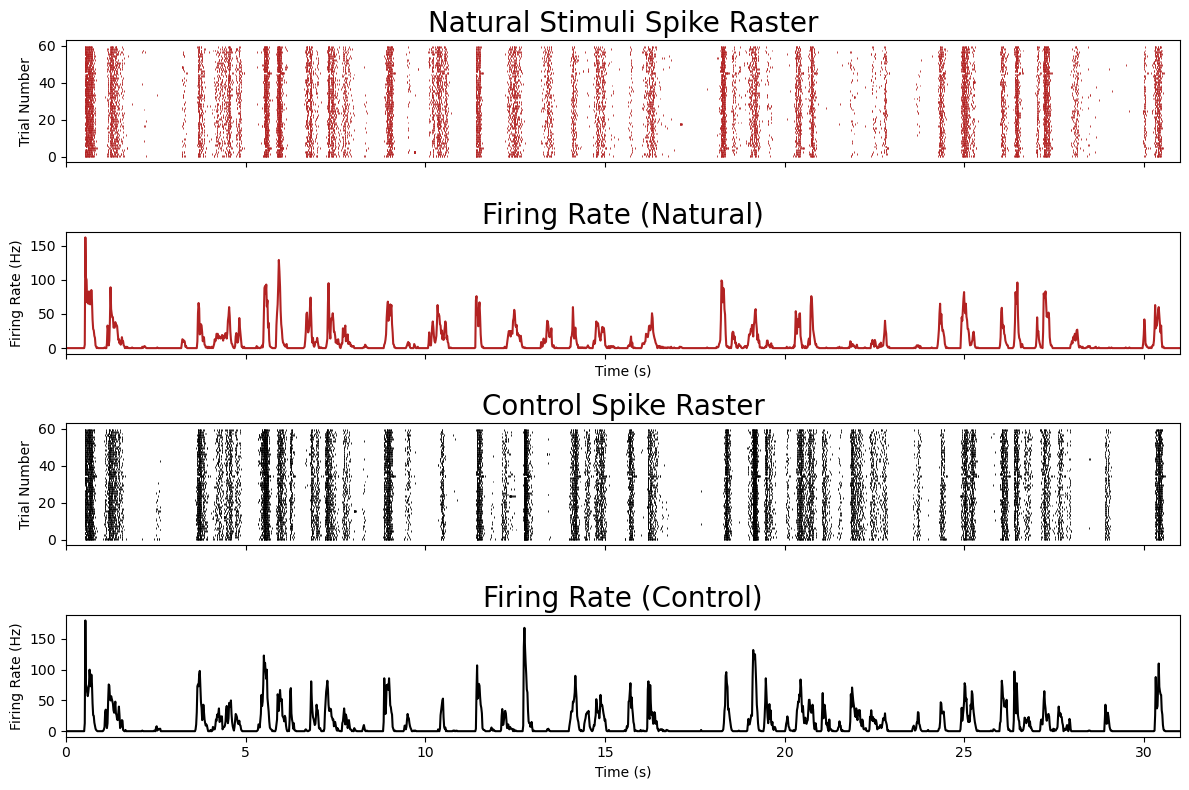

In [96]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

num_trials_n = len(spike_indices_n)
spikes_n = []
for spike_idx_n in range(num_trials_n):
    spikes_in_trial = spike_indices_n[spike_idx_n] / 10000 - delay
    spikes_n.extend(spikes_in_trial)
    ax1.vlines(spikes_in_trial, spike_idx_n, spike_idx_n + 1, 'firebrick', linewidth=0.6)
spikes_n = np.array(spikes_n)
ISI_n = np.mean(np.diff(spikes_n.flatten()))




spikes_c = []
num_trials_c = len(spike_indices_c)
for spike_idx_c in range(num_trials_c):
    spikes_in_trial = spike_indices_c[spike_idx_c] / 10000 - delay
    spikes_c.extend(spikes_in_trial)
    ax3.vlines(spikes_in_trial, spike_idx_c, spike_idx_c + 1, 'k', linewidth=0.6)


spikes_c = np.array(spikes_c)
ISI_c = np.mean(np.diff(spikes_c.flatten()))


minISI = min(ISI_c,ISI_n)

bin_width = 5 * minISI # s
bin_width = 1/60 # s
bins = np.arange(0, 31 + bin_width, bin_width) 
counts_n, bin_edges = np.histogram(spikes_n, bins=bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

ax1.set_ylabel('Trial Number')
ax1.set_title('Natural Stimuli Spike Raster',fontsize = 20)
ax1.set_xlim(0, 31)  

average_spike_count_n = counts_n / num_trials_n
firing_rate_n = average_spike_count_n / bin_width

ax2.plot(bin_centers, firing_rate_n, 'firebrick')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Firing Rate (Hz)')
ax2.set_title('Firing Rate (Natural)',fontsize = 20)


ax3.set_ylabel('Trial Number')
ax3.set_title('Control Spike Raster',fontsize = 20)
ax3.set_xlim(0, 31)  

counts_c, bin_edges = np.histogram(spikes_c, bins=bins)
average_spike_count_c = counts_c / num_trials_c
firing_rate_c = average_spike_count_c / bin_width
ax4.plot(bin_centers, firing_rate_c, 'k')
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('Firing Rate (Hz)')
ax4.set_title('Firing Rate (Control)',fontsize = 20)

plt.tight_layout()
plt.show()

# STA

In [97]:

all_vc = []
all_ac = []
all_r_c = []


for trial_idx in range(len(trajx_c)):
    dpc_x = np.diff(trajx_c[trial_idx])
    dpc_y = np.diff(trajy_c[trial_idx])
    vc_x = dpc_x / dt
    vc_y = dpc_y / dt
    vc = np.sqrt(vc_x**2 + vc_y**2)
    dvc_x = np.diff(vc_x)
    dvc_y = np.diff(vc_y)
    ac_x = dvc_x / dt
    ac_y = dvc_y / dt
    ac = np.sqrt(ac_x**2 + ac_y**2)
    r_c = np.sqrt(trajx_c[trial_idx]**2 + trajy_c[trial_idx]**2)
    
    all_vc.append(vc)
    all_ac.append(ac)
    all_r_c.append(r_c)
    
all_vc = np.array(all_vc) 
all_ac = np.array(all_ac)
all_r_c = np.array(all_r_c)



all_vn = []
all_an = []
all_r_n = []



for trial_idx in range(len(trajx_n)):
    dpn_x = np.diff(trajx_n[trial_idx])
    dpn_y = np.diff(trajy_n[trial_idx])
    vn_x = dpn_x / dt
    vn_y = dpn_y / dt
    vn = np.sqrt(vn_x**2 + vn_y**2)
    dvn_x = np.diff(vn_x)
    dvn_y = np.diff(vn_y)
    an_x = dvn_x / dt
    an_y = dvn_y / dt
    an = np.sqrt(an_x**2 + an_y**2)
    r_n = np.sqrt(trajx_n[trial_idx]**2 + trajy_n[trial_idx]**2)
    
    all_vn.append(vn)
    all_an.append(an)
    all_r_n.append(r_n)



all_vn = np.array(all_vn)
all_an = np.array(all_an)
all_r_n = np.array(all_r_n)


mean_vc = np.nanmean(all_vc)  
mean_ac = np.nanmean(all_ac)

mean_vn = np.nanmean(all_vn)  
mean_an = np.nanmean(all_an)

all_vc_centered = all_vc - mean_vc
all_ac_centered = all_ac - mean_ac

all_vn_centered = all_vn - mean_vn
all_an_centered = all_an - mean_an
all_vc -= mean_vc
all_ac -= mean_ac
all_vn -= mean_vn
all_an -= mean_an

In [98]:

time_window = np.linspace(-T * dt, -dt, T)

d_n = np.zeros((T, len(spike_indices_n), max([len(spikes) for spikes in spike_indices_n])))

d_c = np.zeros((T, len(spike_indices_c), max([len(spikes) for spikes in spike_indices_c])))

sta_v_n = np.full((T, len(spike_indices_n), max([len(spikes) for spikes in spike_indices_n])), np.nan)
sta_a_n = np.full((T, len(spike_indices_n), max([len(spikes) for spikes in spike_indices_n])), np.nan)
sta_x_n = np.full((T, len(spike_indices_n), max([len(spikes) for spikes in spike_indices_n])), np.nan)
sta_y_n = np.full((T, len(spike_indices_n), max([len(spikes) for spikes in spike_indices_n])), np.nan)
sta_r_n = np.full((T, len(spike_indices_n), max([len(spikes) for spikes in spike_indices_n])), np.nan)

sta_v_c = np.full((T, len(spike_indices_c), max([len(spikes) for spikes in spike_indices_c])), np.nan)
sta_a_c = np.full((T, len(spike_indices_c), max([len(spikes) for spikes in spike_indices_c])), np.nan)
sta_x_c = np.full((T, len(spike_indices_c), max([len(spikes) for spikes in spike_indices_c])), np.nan)
sta_y_c = np.full((T, len(spike_indices_c), max([len(spikes) for spikes in spike_indices_c])), np.nan)
sta_r_c = np.full((T, len(spike_indices_c), max([len(spikes) for spikes in spike_indices_c])), np.nan)

for trial_idx, spikes in enumerate(spike_indices_n):
    spike_indices = (spikes.flatten() / 10000 / dt).astype(int)

    for spike_idx, si in enumerate(spike_indices):
        i0 = si - T
        sta_v_n[max(-i0 + 1, 0):, trial_idx, spike_idx] = all_vn[trial_idx][max(i0 - 1, 0):max(si - 1, 0)]
        sta_a_n[max(-i0 + 2, 0):, trial_idx, spike_idx] = all_an[trial_idx][max(i0 - 2, 0):max(si - 2, 0)]
        sta_x_n[max(-i0, 0):, trial_idx, spike_idx] = trajx_n[trial_idx][max(i0, 0):si]
        sta_y_n[max(-i0, 0):, trial_idx, spike_idx] = trajy_n[trial_idx][max(i0, 0):si]
        sta_r_n[max(-i0, 0):, trial_idx, spike_idx] = all_r_n[trial_idx][max(i0, 0):si]
        d_n[max(-i0, 0):, trial_idx, spike_idx] += 1


for trial_idx, spikes in enumerate(spike_indices_c):
    spike_indices = (spikes.flatten() / 10000 / dt).astype(int)

    for spike_idx, si in enumerate(spike_indices):
        i0 = si - T
        sta_v_c[max(-i0 + 1, 0):, trial_idx, spike_idx] = all_vc[trial_idx][max(i0 - 1, 0):max(si - 1, 0)]
        sta_a_c[max(-i0 + 2, 0):, trial_idx, spike_idx] = all_ac[trial_idx][max(i0 - 2, 0):max(si - 2, 0)]
        sta_x_c[max(-i0, 0):, trial_idx, spike_idx] = trajx_c[trial_idx][max(i0, 0):si]
        sta_y_c[max(-i0, 0):, trial_idx, spike_idx] = trajy_c[trial_idx][max(i0, 0):si]
        sta_r_c[max(-i0, 0):, trial_idx, spike_idx] = all_r_c[trial_idx][max(i0, 0):si]
        d_c[max(-i0, 0):, trial_idx, spike_idx] += 1

sta_v_n /= d_n
sta_a_n /= d_n
sta_x_n /= d_n
sta_y_n /= d_n
sta_r_n /= d_n

sta_v_c /= d_c
sta_a_c /= d_c
sta_x_c /= d_c
sta_y_c /= d_c
sta_r_c /= d_c


avg_sta_v_n = np.nanmean(sta_v_n, axis=(1, 2))
avg_sta_a_n = np.nanmean(sta_a_n, axis=(1, 2))
avg_sta_x_n = np.nanmean(sta_x_n, axis=(1, 2))
avg_sta_y_n = np.nanmean(sta_y_n, axis=(1, 2))
avg_sta_r_n = np.nanmean(sta_r_n, axis=(1, 2))

avg_sta_v_c = np.nanmean(sta_v_c, axis=(1, 2))
avg_sta_a_c = np.nanmean(sta_a_c, axis=(1, 2))
avg_sta_x_c = np.nanmean(sta_x_c, axis=(1, 2))
avg_sta_y_c = np.nanmean(sta_y_c, axis=(1, 2))
avg_sta_r_c = np.nanmean(sta_r_c, axis=(1, 2))


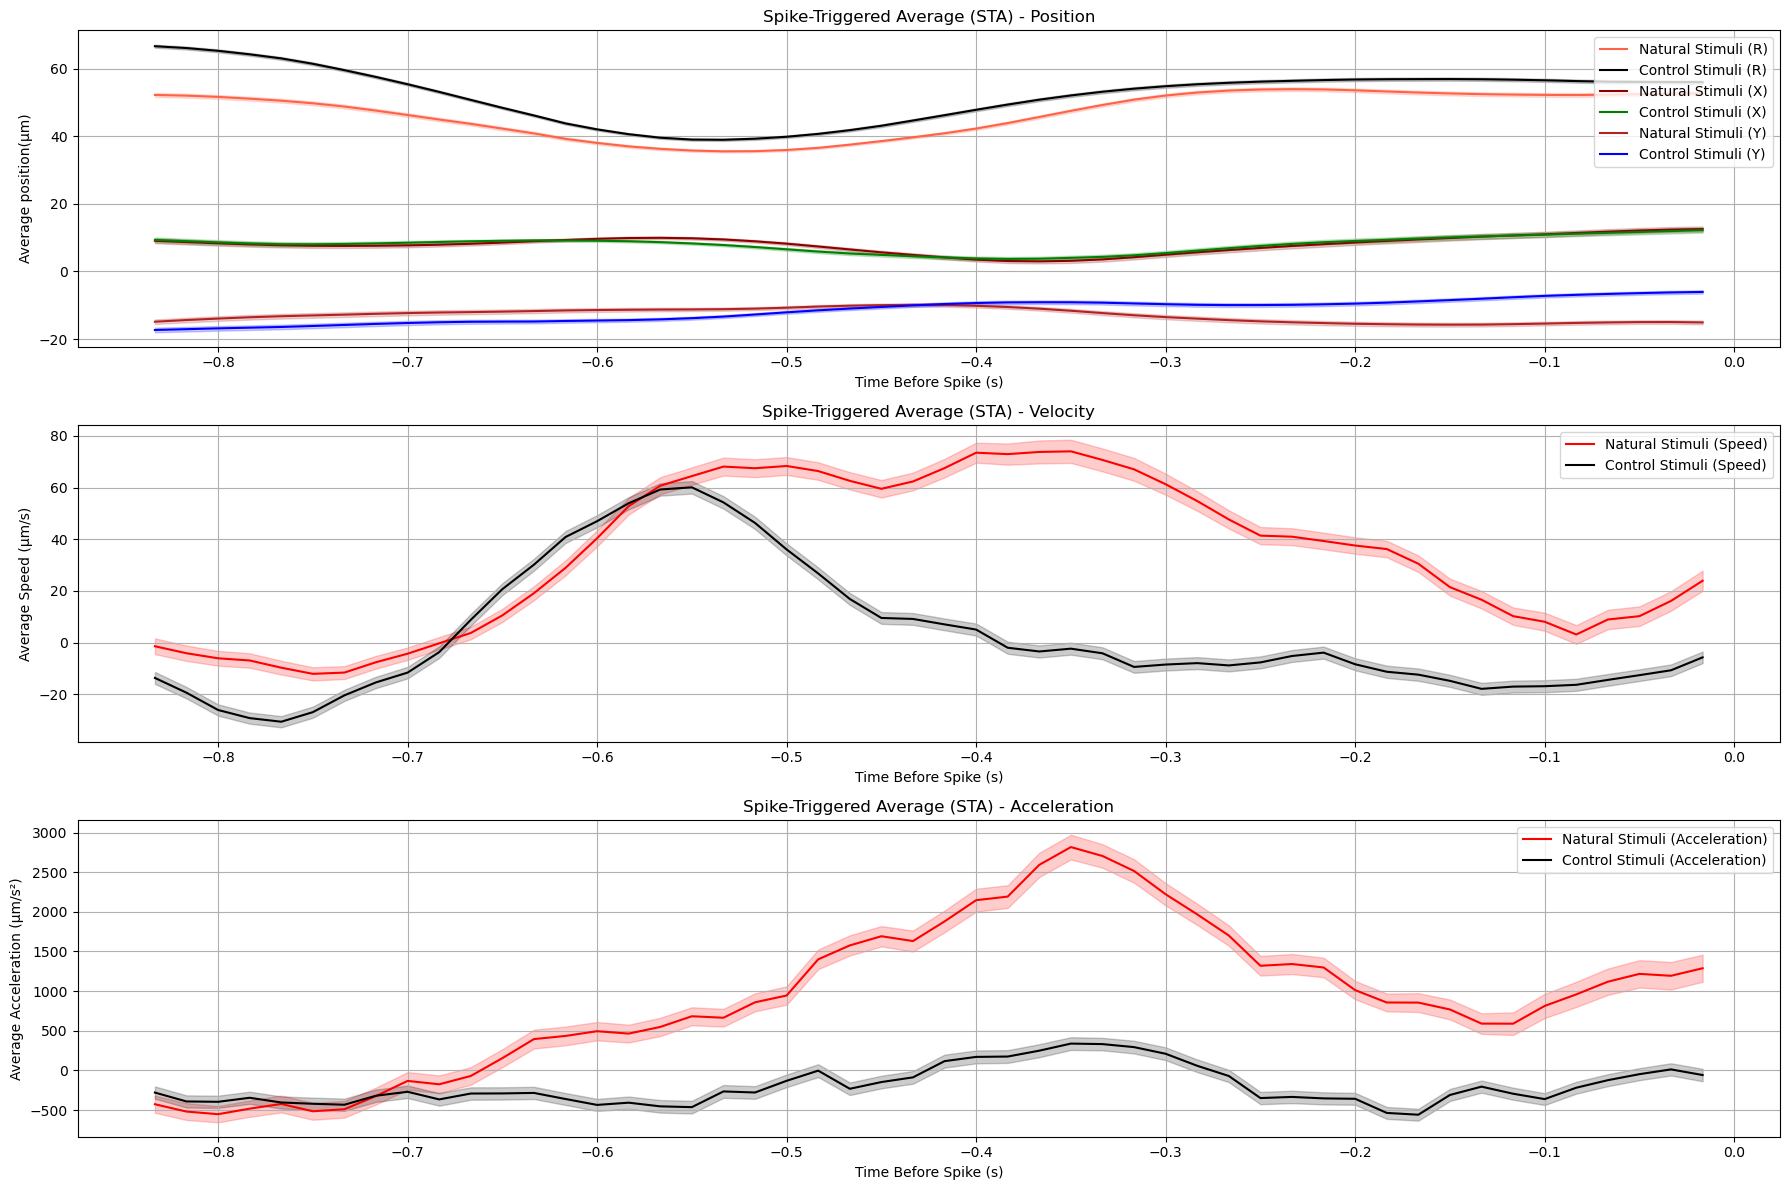

In [99]:
# Plot STA for velocity and acceleration
time_window = np.linspace(-T * dt, -dt, T)

sem_x_n = np.nanstd(sta_x_n.reshape(T, -1), axis=1) / np.sqrt(np.nansum(d_n, axis=(1,2)))
sem_x_c = np.nanstd(sta_x_c.reshape(T, -1), axis=1) / np.sqrt(np.nansum(d_c, axis=(1,2)))
sem_y_n = np.nanstd(sta_y_n.reshape(T, -1), axis=1) / np.sqrt(np.nansum(d_n, axis=(1,2)))
sem_y_c = np.nanstd(sta_y_c.reshape(T, -1), axis=1) / np.sqrt(np.nansum(d_c, axis=(1,2)))
sem_r_n = np.nanstd(sta_r_n.reshape(T, -1), axis=1) / np.sqrt(np.nansum(d_n, axis=(1,2)))
sem_r_c = np.nanstd(sta_r_c.reshape(T, -1), axis=1) / np.sqrt(np.nansum(d_c, axis=(1,2)))


sem_v_n = np.nanstd(sta_v_n.reshape(T, -1), axis=1) / np.sqrt(np.nansum(d_n, axis=(1,2)))
sem_v_c = np.nanstd(sta_v_c.reshape(T, -1), axis=1) / np.sqrt(np.nansum(d_c, axis=(1,2)))

sem_a_n = np.nanstd(sta_a_n.reshape(T, -1), axis=1) / np.sqrt(np.nansum(d_n, axis=(1,2)))
sem_a_c = np.nanstd(sta_a_c.reshape(T, -1), axis=1) / np.sqrt(np.nansum(d_c, axis=(1,2)))

plt.figure(figsize=(18, 12))

# Position
plt.subplot(3, 1, 1)
plt.plot(time_window, avg_sta_r_n, label='Natural Stimuli (R)', color='tomato')
plt.fill_between(time_window,  avg_sta_r_n - 2 * sem_r_n,  avg_sta_r_n + 2 * sem_r_n,color='tomato', alpha=0.2)
plt.plot(time_window, avg_sta_r_c, label='Control Stimuli (R)', color='k')
plt.fill_between(time_window,  avg_sta_r_c - 2 * sem_r_c,  avg_sta_r_c + 2 * sem_r_c,color='k', alpha=0.2)
plt.plot(time_window, avg_sta_x_n, label='Natural Stimuli (X)', color='darkred')
plt.fill_between(time_window,  avg_sta_x_n - 2 * sem_x_n,  avg_sta_x_n + 2 * sem_x_n,color='darkred', alpha=0.2)
plt.plot(time_window, avg_sta_x_c, label='Control Stimuli (X)', color='green')
plt.fill_between(time_window,  avg_sta_x_c - 2 * sem_x_c,  avg_sta_x_c + 2 * sem_x_c,color='green', alpha=0.2)
plt.plot(time_window, avg_sta_y_n, label='Natural Stimuli (Y)', color='firebrick')
plt.fill_between(time_window,  avg_sta_y_n - 2 * sem_y_n,  avg_sta_y_n + 2 * sem_y_n,color='firebrick', alpha=0.2)
plt.plot(time_window, avg_sta_y_c, label='Control Stimuli (Y)', color='blue')
plt.fill_between(time_window,  avg_sta_y_c - 2 * sem_y_c,  avg_sta_y_c + 2 * sem_y_c,color='blue', alpha=0.2)

plt.xlabel('Time Before Spike (s)')
plt.ylabel('Average position(μm)')
plt.title('Spike-Triggered Average (STA) - Position')
plt.legend()
plt.grid(True)

# Velocity
plt.subplot(3, 1, 2)
plt.plot(time_window, avg_sta_v_n, label='Natural Stimuli (Speed)', color='red')
plt.fill_between(time_window,  avg_sta_v_n - 2 * sem_v_n,  avg_sta_v_n + 2 * sem_v_n,color='red', alpha=0.2)
plt.plot(time_window, avg_sta_v_c, label='Control Stimuli (Speed)', color='k')
plt.fill_between(time_window,  avg_sta_v_c - 2 * sem_v_c,  avg_sta_v_c + 2 * sem_v_c,color='k', alpha=0.2)
plt.xlabel('Time Before Spike (s)')
plt.ylabel('Average Speed (μm/s)')
plt.title('Spike-Triggered Average (STA) - Velocity')
plt.legend()
plt.grid(True)

# Acceleration
plt.subplot(3, 1, 3)
plt.plot(time_window, avg_sta_a_n, label='Natural Stimuli (Acceleration)', color='red')
plt.fill_between(time_window,  avg_sta_a_n - 2 * sem_a_n, avg_sta_a_n + 2 * sem_a_n,color='red', alpha=0.2)
plt.plot(time_window, avg_sta_a_c, label='Control Stimuli (Acceleration)', color='k')
plt.fill_between(time_window, avg_sta_a_c - 2 * sem_a_c, avg_sta_a_c + 2 * sem_a_c,color='k', alpha=0.2)
plt.xlabel('Time Before Spike (s)')
plt.ylabel('Average Acceleration (μm/s²)')
plt.title('Spike-Triggered Average (STA) - Acceleration')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# LN-GC model

# stimuli generation

In [100]:

stimuli_n = sg.generate_stimuli(trajx_n[0][0:1800], trajy_n[0][0:1800],board_size=400, diameter=30,fps = 60,pretime = 500,tailtime =500,type='natural',preframes=15,tailframes=45,stimframes=15)  
stimuli_c = sg.generate_stimuli(trajx_c[0][0:1800], trajy_c[0][0:1800],board_size=400, diameter=30,fps = 60,pretime = 500,tailtime =500,type='natural',preframes=15,tailframes=45,stimframes=15)  
stimuli_M = []
for moving_trialidx in range(len(v_M)):
    stimuli_M.append(sg.generate_stimuli(trajx_M[moving_trialidx], trajy_M[moving_trialidx],400,30,60,50,50)) 
print(f"Generated stimuli shape: {stimuli_n.shape}")

Generated stimuli shape: (1860, 401, 401)


In [101]:
np.save('results/stimuli_n.npy', stimuli_n)
np.save('results/stimuli_c.npy', stimuli_c)

# Linear filter

In [102]:
def spatial_filterSF(rf,A=1):

    return A * rf

def gaussian_2d(x, y, sigma_x, sigma_y, A=1, x0=0, y0=0):
    X, Y = np.meshgrid(x, y, indexing='ij')
    return A * np.exp(-((X - x0)**2 / (2 * sigma_x**2) + (Y - y0)**2 / (2 * sigma_y**2)))

def gaussian_2dflatten(x, y, sigma_x, sigma_y,mix, widenratio, A=1, x0=0, y0=0):
    d = gaussian_2d(x=x, y=y, sigma_x = sigma_x, sigma_y = sigma_y, A=A, x0=x0, y0=y0) + gaussian_2d(x=x, y=y, sigma_x = widenratio* sigma_x, sigma_y = widenratio*sigma_y, A=mix*A, x0=x0, y0=y0)
    d = d / np.max(d)
    return d 

def generalized_gaussian_2d(x, y, sigma_x, sigma_y, alpha, A=1.0, x0=0, y0=0):
    """
    2D generalized Gaussian with exponent alpha:
    - alpha = 1: standard Gaussian
    - 0 < alpha < 1: heavier tails (higher kurtosis)
    - alpha > 1: lighter tails
    """
    X, Y = np.meshgrid(x, y, indexing='ij')
    Q = ((X - x0)**2 / (2 * sigma_x**2) +
         (Y - y0)**2 / (2 * sigma_y**2))
    d = A * np.exp(- Q**alpha)
    d = d / d[int((len(x)-1)/2),int((len(x)-1)/2+1)]
    return d   # Normalize to max value of 1


# 2) Student's-t / Cauchy-style kernel
def student_t_2d(x, y, sigma_x, sigma_y, nu, A=1.0, x0=0, y0=0):
    """
    2D Student's-t distribution (heavy-tailed):
    - nu: degrees of freedom. Lower nu -> heavier tails
    - For nu=1: Cauchy (Lorentzian) form
    """
    X, Y = np.meshgrid(x, y, indexing='ij')
    r2 = ((X - x0)**2 / sigma_x**2 + (Y - y0)**2 / sigma_y**2)
    return A * (1 + r2 / nu) ** (-(nu + 1) / 2)
def difference_of_gaussians(x, y, sigma_c, sigma_s, A_c=1, A_s=0.5):
    X, Y = np.meshgrid(x, y, indexing='ij')
    center = A_c * np.exp(-(X**2 + Y**2) / (2 * sigma_c**2))
    surround = A_s * np.exp(-(X**2 + Y**2) / (2 * sigma_s**2))
    return center - surround

def biphasic_temporal_filter(t, p1, p2, tau1, tau2, n):
    t = np.asarray(-t, dtype=float)
    term1 = p1 * (t / tau1)**n * np.exp(-n * (t / tau1 - 1))
    term2 = p2 * (t / tau2)**n * np.exp(-n * (t / tau2 - 1))
    return term1 - term2
def biphasic_temporal_filter_norm0(t, p1, p2, tau1, tau2, n):
    # Ensure t as positive duration array
    t = np.asarray(-t, dtype=float)
    # Compute the two cascaded low-pass terms
    term1 = p1 * (t / tau1)**n * np.exp(-n * (t / tau1 - 1))
    term2 = p2 * (t / tau2)**n * np.exp(-n * (t / tau2 - 1))
    # Combine to biphasic raw filter
    filt = term1 - term2

    area = simpson(filt, t)
    filt -= area / (t[-1] - t[0])
    return filt

def apply_temporal_filter_to_movie(movie, temporal_filter):

    F, = movie.shape  
    T = len(temporal_filter) 

    filtered_movie = np.zeros_like(movie)

    filtered_signal = convolve(movie, temporal_filter, mode='full')[:F]
    
    filtered_movie[:] = filtered_signal

    return filtered_movie

def linear_filter(spatial_rf, noise_input, temporal_filter):   

    T, Y, X = noise_input.shape 
    # x = np.linspace(-(X-1)/2, (X-1)/2, X)
    # y = np.linspace(-(Y-1)/2, (Y-1)/2, Y)
    noise_input = noise_input.astype(np.float32)
    
    # if type == 'gaussian':
    #     spatial_rf = gaussian_2d(x, y, sigma_x, sigma_y, A, x0=0, y0=0) # Shape: (Y,X)
    # if type == 'difference_of_gaussians':
    #     spatial_rf = difference_of_gaussians(x, y, sigma_c, sigma_s, A_c, A_s)  # Shape: (Y,X)
    # if type == 'SFfitting':
    #     spatial_rf = spatial_filterSF(rf=rf_estimated,A=A)
    # if type == 'gaussian_2dflatten':
    #     spatial_rf = gaussian_2dflatten(x, y, sigma_x, sigma_y, mix, widenratio, A, x0=0, y0=0)  # Shape: (Y,X)
    spatial_rf = spatial_rf.astype(np.float32)   
    spatial_filtered_movie = noise_input.reshape((T,Y*X)) @ spatial_rf.reshape((Y*X))  # Shape: (T,)
    filtered_movie = apply_temporal_filter_to_movie(spatial_filtered_movie, temporal_filter)

    return filtered_movie


In [103]:
def apply_nonlinearity(linear_output, method='static', **kwargs):
    if method == 'static':
        return np.maximum(0, linear_output)
    elif method == 'sigmoid':
        gain = kwargs.get('gain', 0.02)
        max_rate = kwargs.get('max_rate', 250.0)
        C = kwargs.get('y', -30)
        return max_rate / (1 + np.exp(-gain * (linear_output+C))) 
    elif method == 'sigmoidgc':
        gain = kwargs.get('gain', 0.05)
        max_rate = kwargs.get('max_rate', 1500.0)
        C = kwargs.get('y', -37256.659)
        return max_rate / (0.04 + np.exp(-gain * (linear_output+165)))  + C
    elif method == 'threshold_linear':
        theta = kwargs.get('theta', 10)
        return np.maximum(0, linear_output - theta)
    elif method == 'threshold_lineargc':
        theta = kwargs.get('theta', 0)
        return np.maximum(0, linear_output - theta)
    elif method == 'powerlaw':
        gamma = kwargs.get('gamma', 0.5)
        return np.maximum(0, np.abs(linear_output)**gamma)
    elif method == 'exponential_saturation':
        alpha = kwargs.get('alpha', 0.1)
        beta = kwargs.get('beta', 1.0)
        return beta * (1 - np.exp(-alpha * linear_output))
    elif method == 'adaptive_gain':
        gain = kwargs.get('gain', 1.0)
        return gain * np.maximum(0, linear_output)
    else:
        raise ValueError("Unknown nonlinearity method")
    


In [104]:
#animation = animate_stimuli(stimuli_SF15[0], x_range=[-200, 200], y_range=[-200, 200], filename="stimuli_SF_60fpsaltered.html")

# Gain control definition

In [105]:
def resample_and_generate_spikes(firing_rates, target_time_bin=1/1200):


    original_time_bin = 1 / 60

    upsampling_factor = int(original_time_bin / target_time_bin)
    if upsampling_factor < 1:
        raise ValueError("Target time bin must be smaller")

    expanded_firing_rates = np.repeat(firing_rates, upsampling_factor, axis=0)


    scaled_rates = expanded_firing_rates * target_time_bin


    spikes = np.random.poisson(scaled_rates)

    return spikes

def gain_control(Lout, B=0.005, tau=11.0):

    T = len(Lout)  
    v_t = np.zeros(T)  
    g_v = np.zeros(T)
    gain_controlled_Lout = np.zeros(T) 
    gain_controlled_Lout[0] = 1 * Lout[0]
    decay_kernel = B * np.exp(-np.arange(T) / tau)

    for t in range(T):
        v_t[t] = np.sum(gain_controlled_Lout[:t] * decay_kernel[:t][::-1]) 
        g_v[t] = 1 if v_t[t] < 0 else 1 / (1 + v_t[t]**4)
        gain_controlled_Lout[t] = g_v[t] * Lout[t]

    return gain_controlled_Lout, g_v


# Parameter settting for model

In [106]:
temporal_filter_V1 = np.load('results/temporal_filter5.npy')
# optimal parameters
# 4 for linear and gain control
# A, multiply the spatial filter
# B, gain control strength
# tau, gain control time window
# pnratio, represents the ratio btw negative part and positive part of temporal filter
# 4 parameters for a sigmoid plus threshold non linear filter


In [107]:
time_para = 5400 # time bin to generate spike
num_modeltrails = 60 #
trajn_feature = all_vn, all_an, all_r_n, trajx_n, trajy_n, dt, time_para
trajc_feature = all_vc, all_ac, all_r_c, trajx_c, trajy_c, dt, time_para
stimttype = 'control_gaussianflatten' # 'natural', 'control', 'natural_gaussian', 'natural_w/o_gaincontrol', 'natural_gaussianflatten'
rf_estimated = np.load('results/rf_estimated.npy')


# spatial filter (gussian

sigma_x, sigma_y = 26,26  #normal

if stimttype == 'natural':
    traj_feature = trajn_feature
    all_v = all_vn
    all_a = all_an
    all_r = all_r_n
    trajx = trajx_n
    trajy = trajy_n
    stimuli = stimuli_n
    firing_rate = firing_rate_n 
    t_sampling = np.linspace(0,1860,1860)
    
    A     = 1
    B     = 0.000505
    tau   = 8
    pnratio = 0.631
    
    gain = 0.00213
    max_rate = 200
    y = -800
    theta = 30
    T, X_SF, Y_SF = stimuli.shape 
    x_SF = np.linspace(-(X_SF-1)/2, (X_SF-1)/2, X_SF)
    y_SF = np.linspace(-(Y_SF-1)/2, (Y_SF-1)/2, Y_SF)
    spatial_rf = spatial_filterSF(rf=rf_estimated,A=A)
    
if stimttype == 'control':
    traj_feature = trajc_feature
    all_v = all_vc
    all_a = all_ac
    all_r = all_r_c
    trajx = trajx_c
    trajy = trajy_c
    stimuli = stimuli_c
    firing_rate = firing_rate_c
    t_sampling = np.linspace(0,1860,1860)
    A       = 1
    B       = 0.0005486
    tau     = 9
    pnratio = 0.6252
    gain = 0.00213
    max_rate = 200
    y = -800
    theta = 30
    T, X_SF, Y_SF = stimuli.shape 
    x_SF = np.linspace(-(X_SF-1)/2, (X_SF-1)/2, X_SF)
    y_SF = np.linspace(-(Y_SF-1)/2, (Y_SF-1)/2, Y_SF)
    spatial_rf = spatial_filterSF(rf=rf_estimated,A=A)
if stimttype == 'movingobject':
    moving_trialidx = 10
    stimuli = stimuli_M[moving_trialidx]
    t_sampling = np.linspace(0,55,55)
    T, X_SF, Y_SF = stimuli.shape 
    x_SF = np.linspace(-(X_SF-1)/2, (X_SF-1)/2, X_SF)
    y_SF = np.linspace(-(Y_SF-1)/2, (Y_SF-1)/2, Y_SF)

if stimttype == 'natural_gaussian':
    traj_feature = trajn_feature
    all_v = all_vn
    all_a = all_an
    all_r = all_r_n
    trajx = trajx_n
    trajy = trajy_n
    stimuli = stimuli_n
    firing_rate = firing_rate_n 
    t_sampling = np.linspace(0,1860,1860)
    theta = 30
    A     = 1
    B       = 0.000698
    tau     = 10
    pnratio = 0.631
    gain = 0.00213
    max_rate = 200
    y = -800
    T, X_SF, Y_SF = stimuli.shape 
    x_SF = np.linspace(-(X_SF-1)/2, (X_SF-1)/2, X_SF)
    y_SF = np.linspace(-(Y_SF-1)/2, (Y_SF-1)/2, Y_SF)
    spatial_rf = gaussian_2d(x_SF, y_SF, sigma_x, sigma_y, A, x0=0, y0=0) # Shape: (Y,X)


if stimttype == 'control_gaussian':
    traj_feature = trajc_feature
    all_v = all_vc
    all_a = all_ac
    all_r = all_r_c
    trajx = trajx_c
    trajy = trajy_c
    stimuli = stimuli_c
    firing_rate = firing_rate_c
    t_sampling = np.linspace(0,1860,1860)
    theta = 30
    A     = 1
    B       = 0.000698
    tau     = 10
    pnratio = 0.631
    gain = 0.00213
    max_rate = 200
    y = -800
    T, X_SF, Y_SF = stimuli.shape 
    x_SF = np.linspace(-(X_SF-1)/2, (X_SF-1)/2, X_SF)
    y_SF = np.linspace(-(Y_SF-1)/2, (Y_SF-1)/2, Y_SF)
    spatial_rf = gaussian_2d(x_SF, y_SF, sigma_x, sigma_y, A, x0=0, y0=0) # Shape: (Y,X)
if stimttype == 'natural_w/o_gaincontrol':
    traj_feature = trajn_feature
    all_v = all_vn
    all_a = all_an
    all_r = all_r_n
    trajx = trajx_n
    trajy = trajy_n
    stimuli = stimuli_n
    firing_rate = firing_rate_n 
    t_sampling = np.linspace(0,1860,1860)
    theta = 20
    A     = 1
    B     = 0
    tau   = 22
    pnratio = 0.5687064327358631
    gain = 0.0015
    max_rate = 200
    y = -1559
    T, X_SF, Y_SF = stimuli.shape 
    x_SF = np.linspace(-(X_SF-1)/2, (X_SF-1)/2, X_SF)
    y_SF = np.linspace(-(Y_SF-1)/2, (Y_SF-1)/2, Y_SF)
    spatial_rf = spatial_filterSF(rf=rf_estimated,A=A)
if stimttype == 'control_w/o_gaincontrol':
    traj_feature = trajc_feature
    all_v = all_vc
    all_a = all_ac
    all_r = all_r_c
    trajx = trajx_c
    trajy = trajy_c
    stimuli = stimuli_c
    firing_rate = firing_rate_c
    t_sampling = np.linspace(0,1860,1860)
    theta = 20
    A     = 1
    B     = 0
    tau   = 22
    pnratio = 0.5687064327358631
    gain = 0.0015
    max_rate = 200
    y = -1559
    T, X_SF, Y_SF = stimuli.shape 
    x_SF = np.linspace(-(X_SF-1)/2, (X_SF-1)/2, X_SF)
    y_SF = np.linspace(-(Y_SF-1)/2, (Y_SF-1)/2, Y_SF)
    spatial_rf = spatial_filterSF(rf=rf_estimated,A=A)
if stimttype == 'natural_gaussianflatten':
    traj_feature = trajn_feature
    all_v = all_vn
    all_a = all_an
    all_r = all_r_n
    trajx = trajx_n
    trajy = trajy_n
    stimuli = stimuli_n
    firing_rate = firing_rate_n 
    sigma_x, sigma_y = 22.6,22.6  #normal
    t_sampling = np.linspace(0,1860,1860)
    theta = 30
    A     = 1
    B       = 0.000661
    tau     = 8
    mix     = 0.93364567
    widenratio = 2.347
    pnratio = 0.631
    gain = 0.00213
    max_rate = 200
    y = -800

    B       = 0.0010139495181741842
    tau     = 8
    mix     = 0.28259094509159255
    widenratio = 3.690360562804726


    sigma_x,sigma_y = 14.179272158805905,14.179272158805905
    B       = 0.0006058055592789192
    tau     = 14.227927689087036
    mix     = 0.3544483815254731
    widenratio = 3.132761307300863
    gain    = 0.004545293796018254
    max_rate = 187.8839335009455
    y = -190.96937964264328
    theta = 62.14539986205705    
    T, X_SF, Y_SF = stimuli.shape 
    x_SF = np.linspace(-(X_SF-1)/2, (X_SF-1)/2, X_SF)
    y_SF = np.linspace(-(Y_SF-1)/2, (Y_SF-1)/2, Y_SF)
    spatial_rf = gaussian_2dflatten(x_SF, y_SF, sigma_x, sigma_y, mix, widenratio, A, x0=0, y0=0)  # Shape: (Y,X)
if stimttype == 'control_gaussianflatten':
    traj_feature = trajc_feature
    all_v = all_vc
    all_a = all_ac
    all_r = all_r_c
    trajx = trajx_c
    trajy = trajy_c
    stimuli = stimuli_c
    firing_rate = firing_rate_c 
    sigma_x, sigma_y = 22.6,22.6  #normal
    t_sampling = np.linspace(0,1860,1860)
    theta = 30
    A     = 1
    B       = 0.000661
    tau     = 8
    mix     = 0.93364567
    widenratio = 2.347
    pnratio = 0.631
    gain = 0.00213
    max_rate = 200
    y = -800

    B       = 0.0010139495181741842

    mix     = 0.28259094509159255
    widenratio = 3.690360562804726

    sigma_x,sigma_y   = 12.271325068425213,12.271325068425213
    B       = 0.0007810624726927833
    tau     = 6.929137851428139
    mix     = 0.49275070289612133
    widenratio = 3.2885788095100805
    gain    = 0.005167895796580307
    max_rate = 181.81073029192413
    y = -84.77972253021717
    theta = 79.69957192815914
    T, X_SF, Y_SF = stimuli.shape 
    x_SF = np.linspace(-(X_SF-1)/2, (X_SF-1)/2, X_SF)
    y_SF = np.linspace(-(Y_SF-1)/2, (Y_SF-1)/2, Y_SF)
    spatial_rf = gaussian_2dflatten(x_SF, y_SF, sigma_x, sigma_y, mix, widenratio, A, x0=0, y0=0)  # Shape: (Y,X)

if stimttype == 'natural_gaussianGen':
    traj_feature = trajn_feature
    all_v = all_vn
    all_a = all_an
    all_r = all_r_n
    trajx = trajx_n
    trajy = trajy_n
    stimuli = stimuli_n
    firing_rate = firing_rate_n 

    t_sampling = np.linspace(0,1860,1860)


    A =1
    pnratio = 1
    sigma_x,sigma_y = 17.47092326245375,17.47092326245375
    B       = 0.0020726650171981505
    tau     = 7.882508245161932
    alpha   = 0.6406881081699589
    gain    = 0.0067756980878963535
    max_rate = 159.9339258354442
    y = -21.160840485288347
    theta = 74.43809001411122
    T, X_SF, Y_SF = stimuli.shape 
    x_SF = np.linspace(-(X_SF-1)/2, (X_SF-1)/2, X_SF)
    y_SF = np.linspace(-(Y_SF-1)/2, (Y_SF-1)/2, Y_SF)
    spatial_rf = generalized_gaussian_2d(x_SF, y_SF, sigma_x, sigma_y, alpha, A=1.0, x0=0, y0=0) # Shape: (Y,X)


if stimttype == 'control_gaussianGen':
    traj_feature = trajc_feature
    all_v = all_vc
    all_a = all_ac
    all_r = all_r_c
    trajx = trajx_c
    trajy = trajy_c
    stimuli = stimuli_c
    firing_rate = firing_rate_c 

    t_sampling = np.linspace(0,1860,1860)


    A =1
    sigma_x,sigma_y = 19.236720868702694,19.236720868702694
    B       = 0.0005699356321379259
    tau     = 6.484309775177842
    alpha   = 0.6546156922496472
    gain    = 0.008351077202947548
    max_rate = 170.6176092399276
    y = -79.68722771262551
    theta = 80.52951256652139
    T, X_SF, Y_SF = stimuli.shape 
    x_SF = np.linspace(-(X_SF-1)/2, (X_SF-1)/2, X_SF)
    y_SF = np.linspace(-(Y_SF-1)/2, (Y_SF-1)/2, Y_SF)
    spatial_rf = generalized_gaussian_2d(x_SF, y_SF, sigma_x, sigma_y, alpha, A=1.0, x0=0, y0=0) # Shape: (Y,X)


if stimttype == 'natural_student_t':
    A =1
    traj_feature = trajn_feature
    all_v = all_vn
    all_a = all_an
    all_r = all_r_n
    trajx = trajx_n
    trajy = trajy_n
    stimuli = stimuli_n
    firing_rate = firing_rate_n 
    t_sampling = np.linspace(0,1860,1860)

    sigma_x,sigma_y = 14.916074929510014,14.916074929510014
    B       = 0.002840541356499131
    tau     = 5.061818526494731
    nu      = 0.9911028986301904
    gain    = 0.008882754610280263
    max_rate = 197.7624061798797
    y = -18.452088835880147
    theta = 91.32321642514742
    # gain = 0.00213
    # max_rate = 200
    # y = -800
    # theta = 30
    T, X_SF, Y_SF = stimuli.shape 
    x_SF = np.linspace(-(X_SF-1)/2, (X_SF-1)/2, X_SF)
    y_SF = np.linspace(-(Y_SF-1)/2, (Y_SF-1)/2, Y_SF)
    spatial_rf = student_t_2d(x_SF, y_SF, sigma_x, sigma_y, nu, A=1, x0=0, y0=0)


if stimttype == 'control_student_t':
    A =1
    traj_feature = trajc_feature
    all_v = all_vc
    all_a = all_ac
    all_r = all_r_c
    trajx = trajx_c
    trajy = trajy_c
    stimuli = stimuli_c
    firing_rate = firing_rate_c 
    t_sampling = np.linspace(0,1860,1860)
    sigma_x,sigma_y = 19.02857796677332,19.02857796677332
    B       = 0.0010595926581067512
    tau     = 5.996829080986789
    nu      = 1.5659527057147167
    gain    = 0.005387110123236081
    max_rate = 204.2292354819619
    y = -42.899625911306494
    theta = 92.86965584673743
    T, X_SF, Y_SF = stimuli.shape 
    x_SF = np.linspace(-(X_SF-1)/2, (X_SF-1)/2, X_SF)
    y_SF = np.linspace(-(Y_SF-1)/2, (Y_SF-1)/2, Y_SF)
    spatial_rf = student_t_2d(x_SF, y_SF, sigma_x, sigma_y, nu, A=1, x0=0, y0=0)
# temporal filter 

# temporal filter 
t_temporalfitted = np.linspace(-2000/3,0, 40) 
reversed_temp_rfTemp = temporal_filter_V1[::-1]
reversed_temp_rf = np.concatenate((reversed_temp_rfTemp[0:8], reversed_temp_rfTemp[8:] * pnratio))

# Spatial Filter Fig

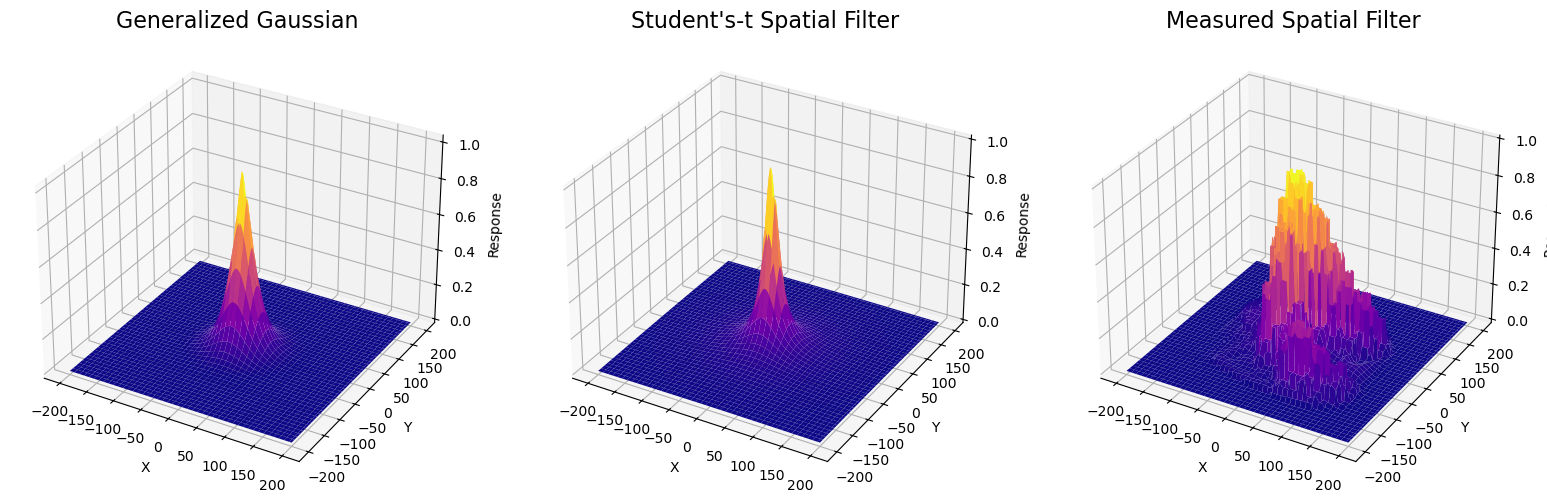

In [108]:

from mpl_toolkits.mplot3d import Axes3D
# Assume x_SF, y_SF, spatial_rf_gauss, spatial_rf_student_t, spatial_rf_measured are already defined
# Example: spatial_rf_gauss = generalized_gaussian_2d(x_SF, y_SF, sigma_x, sigma_y, alpha, A=1.0, x0=0, y0=0)
#          spatial_rf_student_t = student_t_2d(x_SF, y_SF, sigma_x, sigma_y, nu, A=1, x0=0, y0=0)
#          spatial_rf_measured = ... (your measured filter)


spatial_rf_gauss = generalized_gaussian_2d(x_SF, y_SF, 17.47092326245375,17.47092326245375,0.6406881081699589, A=1.0, x0=0, y0=0)
spatial_rf_student_t =  student_t_2d(x_SF, y_SF,14.916074929510014,14.916074929510014,0.9911028986301904, A=1, x0=0, y0=0)

X, Y = np.meshgrid(x_SF, y_SF)

fig = plt.figure(figsize=(16, 5))

# Generalized Gaussian
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(X, Y, spatial_rf_gauss, cmap='plasma')
ax1.set_title("Generalized Gaussian", fontsize=16)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Response')

# Student's-t
ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(X, Y, spatial_rf_student_t, cmap='plasma')
ax2.set_title("Student's-t Spatial Filter", fontsize=16)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Response')

# Measured/Estimated
ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_surface(X, Y, rf_estimated, cmap='plasma')
ax3.set_title("Measured Spatial Filter", fontsize=16)
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_zlabel('Response')

plt.tight_layout()
plt.show()

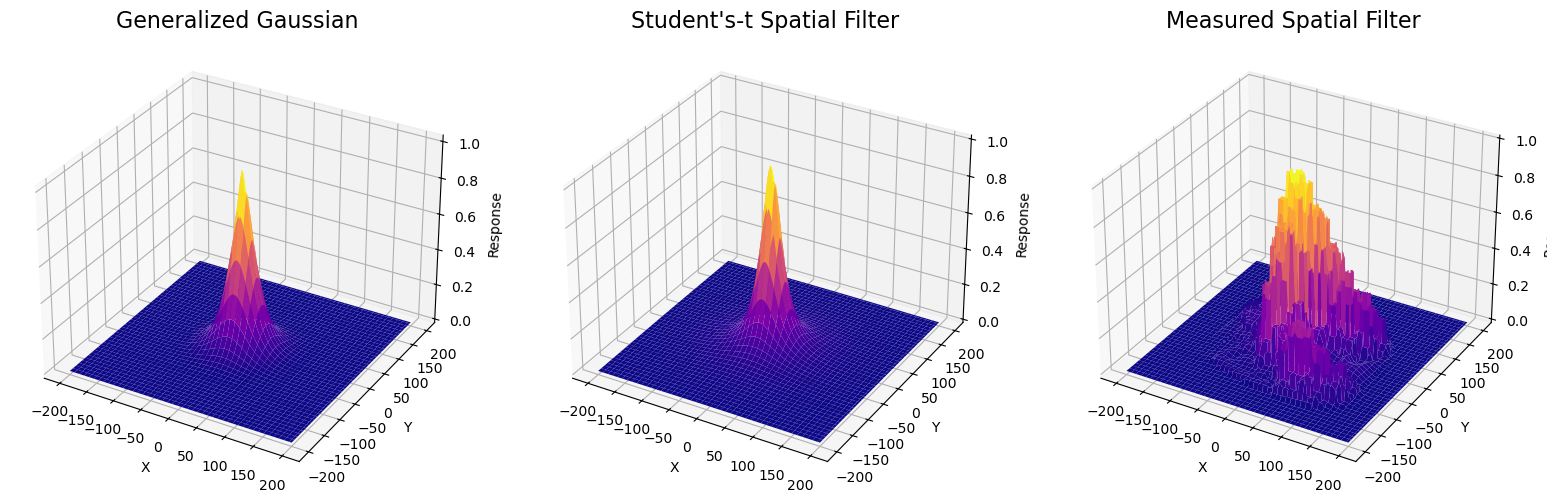

In [109]:


# Assume x_SF, y_SF, spatial_rf_gauss, spatial_rf_student_t, spatial_rf_measured are already defined
# Example: spatial_rf_gauss = generalized_gaussian_2d(x_SF, y_SF, sigma_x, sigma_y, alpha, A=1.0, x0=0, y0=0)
#          spatial_rf_student_t = student_t_2d(x_SF, y_SF, sigma_x, sigma_y, nu, A=1, x0=0, y0=0)
#          spatial_rf_measured = ... (your measured filter)


spatial_rf_gauss = generalized_gaussian_2d(x_SF, y_SF,19.236720868702694,19.236720868702694,0.6546156922496472, A=1.0, x0=0, y0=0)
spatial_rf_student_t =  student_t_2d(x_SF, y_SF, 19.02857796677332,19.02857796677332,1.5659527057147167, A=1, x0=0, y0=0)

X, Y = np.meshgrid(x_SF, y_SF)

fig = plt.figure(figsize=(16, 5))

# Generalized Gaussian
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(X, Y, spatial_rf_gauss, cmap='plasma')
ax1.set_title("Generalized Gaussian", fontsize=16)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Response')

# Student's-t
ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(X, Y, spatial_rf_student_t, cmap='plasma')
ax2.set_title("Student's-t Spatial Filter", fontsize=16)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Response')

# Measured/Estimated
ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_surface(X, Y, rf_estimated, cmap='plasma')
ax3.set_title("Measured Spatial Filter", fontsize=16)
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_zlabel('Response')

plt.tight_layout()
plt.show()

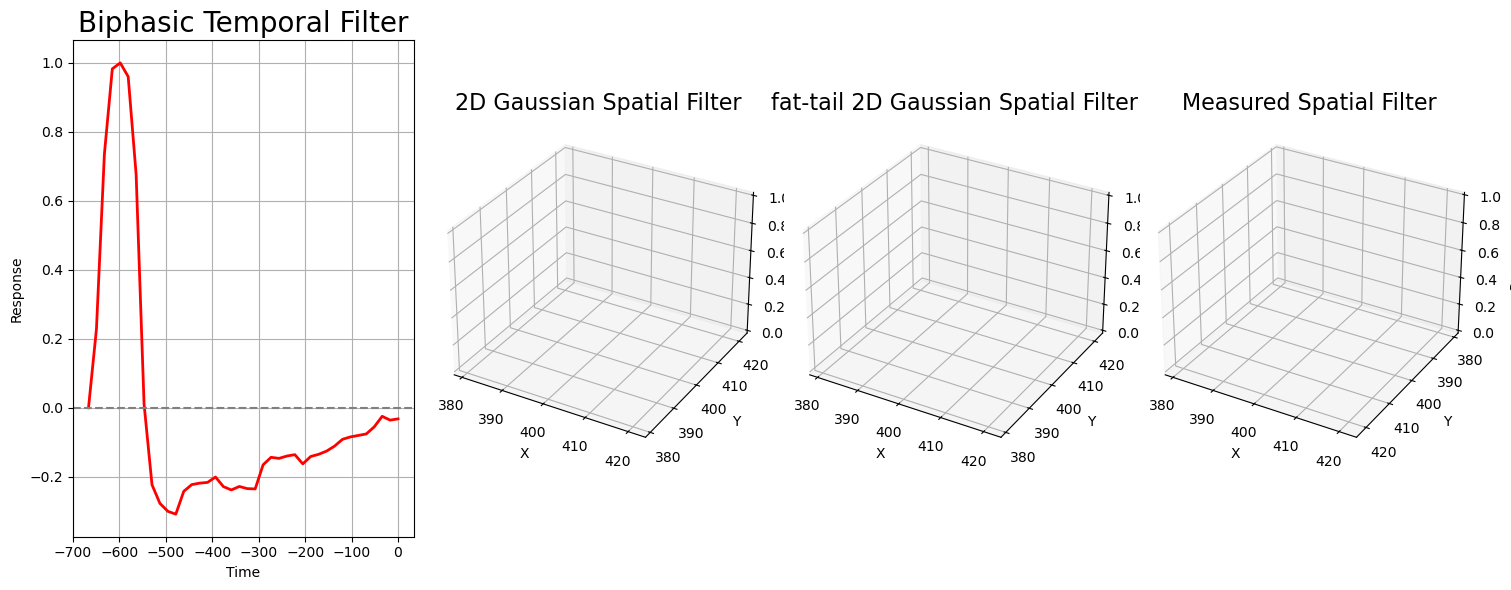

In [110]:


spatial_rf1 = gaussian_2d(x_SF, y_SF, 26,26,A = 1)

spatial_rf2 = gaussian_2dflatten(x_SF, y_SF, sigma_x, sigma_y, widenratio,mix, A=1, x0=0, y0=0)
spatial_rf3 = spatial_filterSF(rf_estimated,A=1)
fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(141)
# ax1.plot(t_temporal, temp_rf, label=f'Temporal Filter', color='b', linewidth=2)
ax1.plot(t_temporalfitted,reversed_temp_rf, label=f'Reversed Temporal Filter', color='r', linewidth=2)
ax1.axhline(0, color='gray', linestyle='--')  # Add a reference horizontal line at 0
ax1.grid(True)
ax1.set_title('Biphasic Temporal Filter',fontsize=20)
ax1.set_xlabel('Time')
ax1.set_ylabel('Response')


ax2 = fig.add_subplot(142, projection='3d')
ax2.plot_surface(X_SF,Y_SF, spatial_rf1, cmap='plasma')
ax2.set_title("2D Gaussian Spatial Filter",fontsize=16)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Response')

ax3 = fig.add_subplot(143, projection='3d')
ax3.plot_surface(X_SF,Y_SF, spatial_rf2, cmap='plasma')
ax3.set_title("fat-tail 2D Gaussian Spatial Filter",fontsize=16)
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_zlabel('Response')

ax4 = fig.add_subplot(144, projection='3d')
ax4.plot_surface(X_SF,Y_SF, spatial_rf3, cmap='plasma')
ax4.set_title("Measured Spatial Filter",fontsize=16)
# ax4.invert_xaxis()
ax4.invert_yaxis()
ax4.set_xlabel('X')
ax4.set_ylabel('Y')
ax4.set_zlabel('Response')
plt.tight_layout()
plt.show()

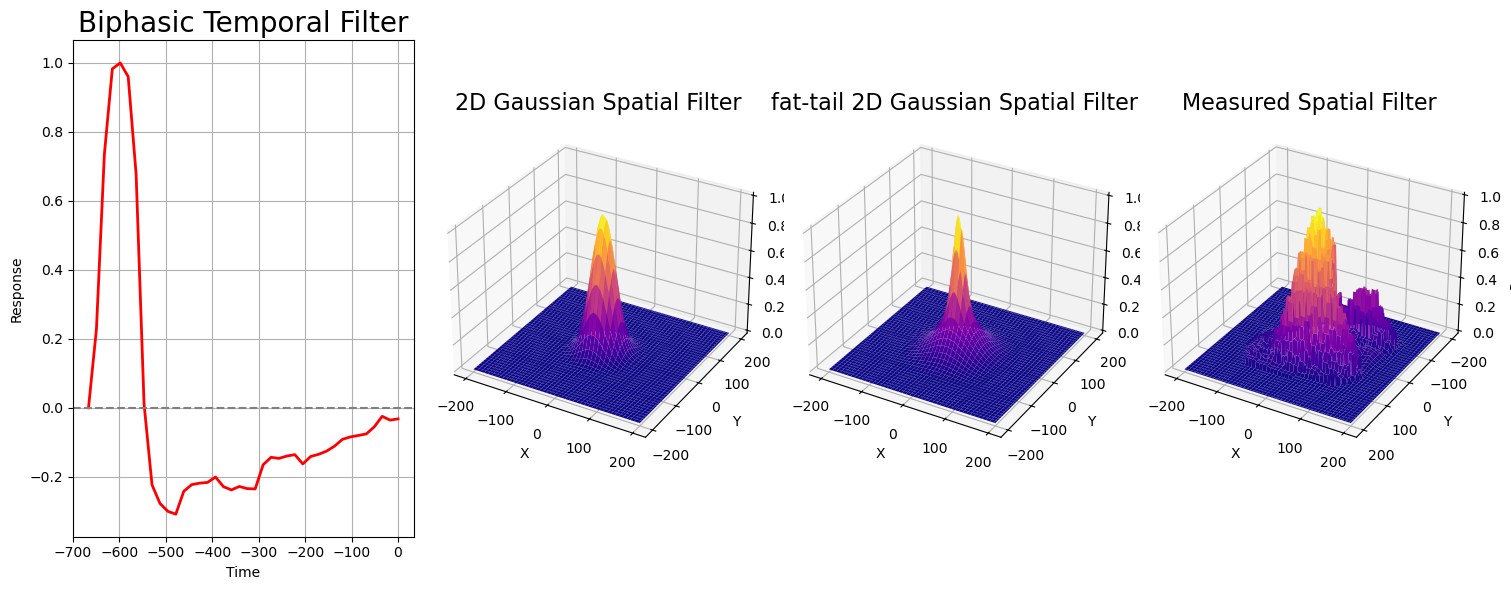

In [111]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

spatial_rf1 = gaussian_2d(x_SF, y_SF,26,26, A=1)
spatial_rf2 = gaussian_2dflatten(x_SF, y_SF, sigma_x, sigma_y, widenratio, mix, A=1, x0=0, y0=0)
spatial_rf3 = spatial_filterSF(rf_estimated, A=1)

# Create meshgrid for 3D plotting
X_mesh, Y_mesh = np.meshgrid(x_SF, y_SF)

fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(141)
ax1.plot(t_temporalfitted, reversed_temp_rf, label=f'Reversed Temporal Filter', color='r', linewidth=2)
ax1.axhline(0, color='gray', linestyle='--')
ax1.grid(True)
ax1.set_title('Biphasic Temporal Filter', fontsize=20)
ax1.set_xlabel('Time')
ax1.set_ylabel('Response')

ax2 = fig.add_subplot(142, projection='3d')
ax2.plot_surface(X_mesh, Y_mesh, spatial_rf1, cmap='plasma')
ax2.set_title("2D Gaussian Spatial Filter", fontsize=16)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Response')

ax3 = fig.add_subplot(143, projection='3d')
ax3.plot_surface(X_mesh, Y_mesh, spatial_rf, cmap='plasma')
ax3.set_title("fat-tail 2D Gaussian Spatial Filter", fontsize=16)
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_zlabel('Response')

ax4 = fig.add_subplot(144, projection='3d')
ax4.plot_surface(X_mesh, Y_mesh, spatial_rf3, cmap='plasma')
ax4.set_title("Measured Spatial Filter", fontsize=16)
ax4.invert_yaxis()
ax4.set_xlabel('X')
ax4.set_ylabel('Y')
ax4.set_zlabel('Response')

plt.tight_layout()
plt.show()

# NonLinear

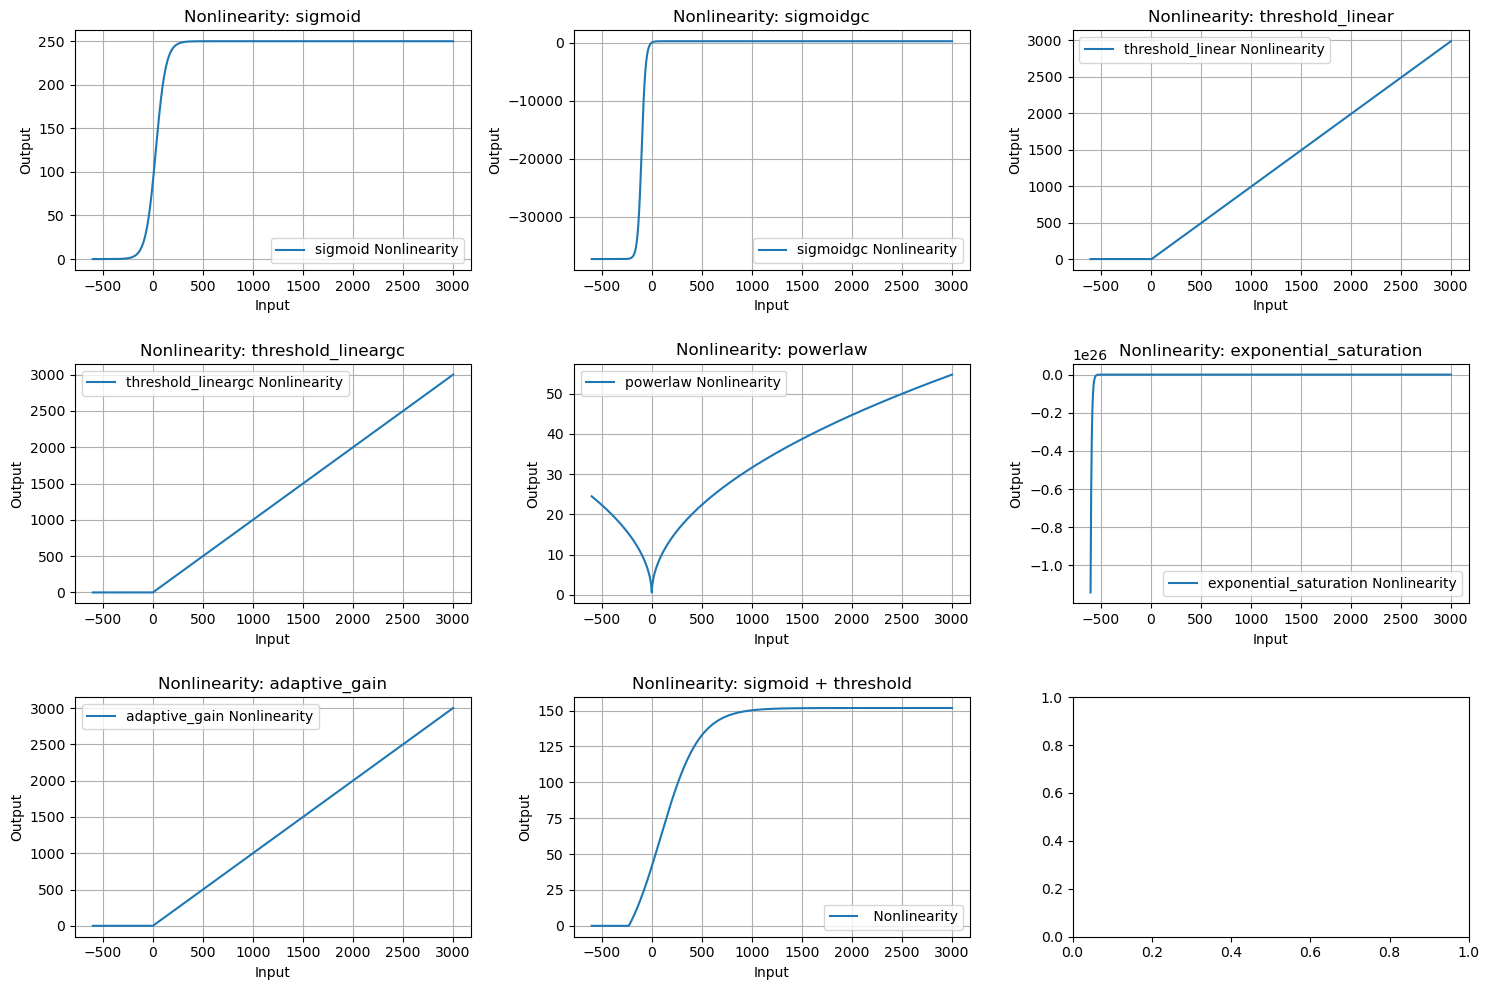

In [112]:
nonlinear_methods = [ 'sigmoid','sigmoidgc', 'threshold_linear','threshold_lineargc','powerlaw', 'exponential_saturation', 'adaptive_gain' ]
outputs = {}

tNN = np.linspace(-600, 3000, 1800)

tLN = apply_nonlinearity(apply_nonlinearity(tNN, method='sigmoid',gain = gain, max_rate = max_rate, y = y), method='threshold_linear',theta = 30)

for method in nonlinear_methods:
    outputs[method] = apply_nonlinearity(tNN, method=method)

fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.ravel()

for i, method in enumerate(nonlinear_methods):
    axes[i].plot(tNN, outputs[method], label=f'{method} Nonlinearity')
    axes[i].set_title(f'Nonlinearity: {method}')
    axes[i].set_xlabel('Input')
    axes[i].set_ylabel('Output')
    axes[i].grid(True)
    axes[i].legend()

axes[7].plot(tNN, tLN, label=f' Nonlinearity')
axes[7].set_title(f'Nonlinearity: sigmoid + threshold')
axes[7].set_xlabel('Input')
axes[7].set_ylabel('Output')
axes[7].grid(True)
axes[7].legend()

plt.tight_layout()
plt.show()

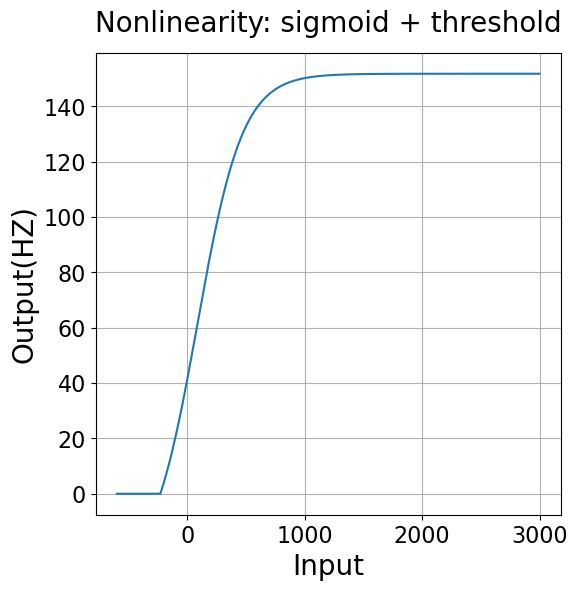

In [113]:
fig, ax0 = plt.subplots(1,1, figsize=(6,6))



ax0.plot(tNN, tLN, label=f' Nonlinearity')
ax0.set_title(f'Nonlinearity: sigmoid + threshold',fontsize =20, pad=15)
ax0.set_xlabel('Input',fontsize =20)
ax0.set_ylabel('Output(HZ)',fontsize =20)
ax0.tick_params(axis='both', which='major', labelsize=16)
ax0.grid(True)


# model output

In [114]:
# LN model
spike_trainLN = []
LoutLN = linear_filter(spatial_rf, stimuli, reversed_temp_rf)
LNoutLN = apply_nonlinearity(apply_nonlinearity(LoutLN, method='sigmoid',gain = gain, max_rate = max_rate, y = y), method='threshold_linear',theta = theta)

time_bin = 1/time_para
for trial in range(num_modeltrails):
    spikingindx=(resample_and_generate_spikes(LNoutLN, time_bin))
    spike_trainLN.append(np.where(spikingindx > 0))


#LN model with gain control
spike_trainGC = []
LoutGC = linear_filter(spatial_rf, stimuli, reversed_temp_rf)
LoutGC, g = gain_control(LoutGC, B, tau)
LNoutGC = apply_nonlinearity(apply_nonlinearity(LoutGC, 'sigmoid',gain = gain, max_rate = max_rate, y = y), method='threshold_linear',theta = theta)
time_bin = 1/time_para
for trial in range(num_modeltrails):
    spikingindx=(resample_and_generate_spikes(LNoutGC, time_bin))
    spike_trainGC.append(np.where(spikingindx > 0))

In [136]:
with open('results/spike_trainGC.pkl', 'wb') as f:
    pickle.dump(spike_trainGC, f)

C:\Users\Komeijiiiii\AppData\Local\Temp\ipykernel_36644\2134489185.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


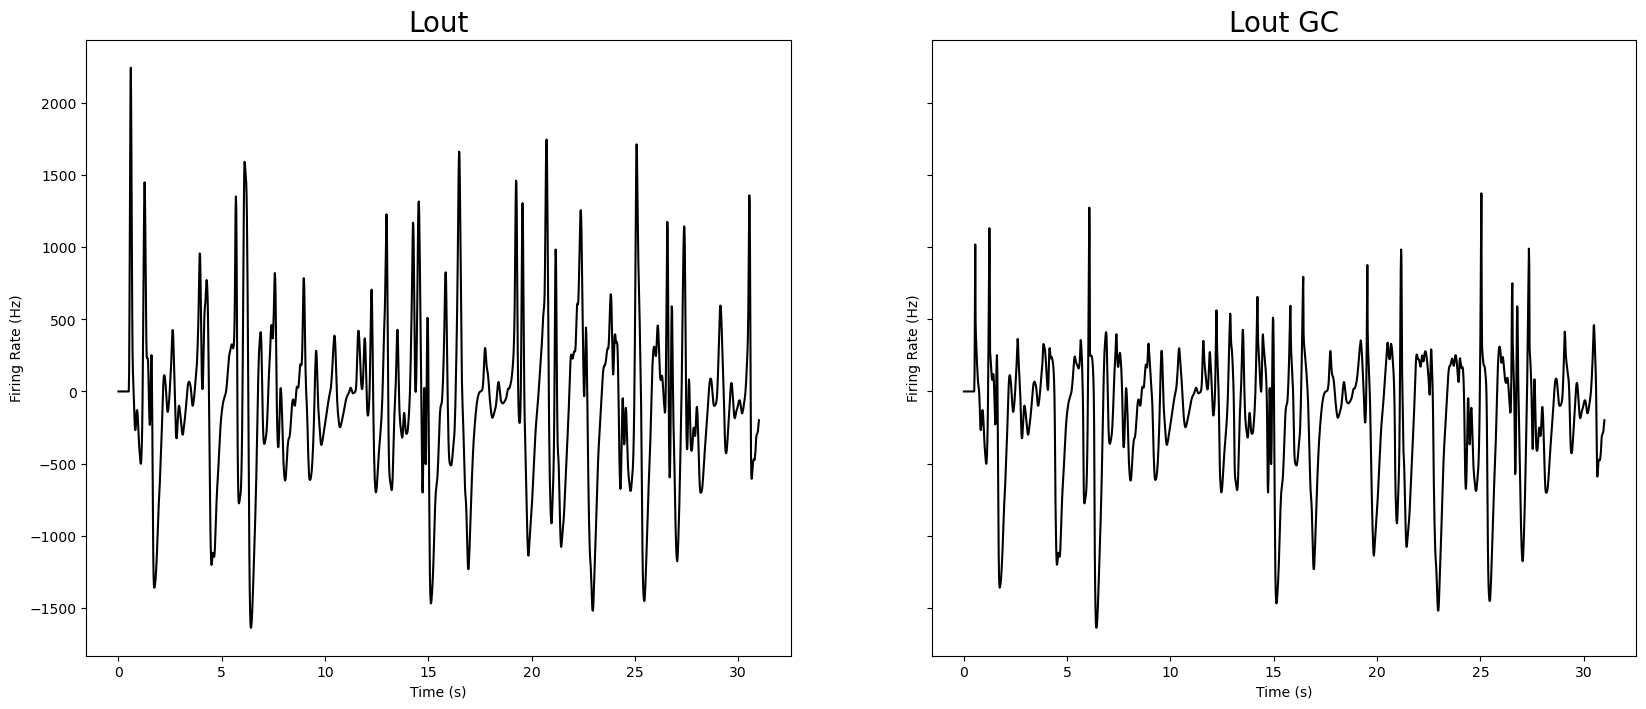

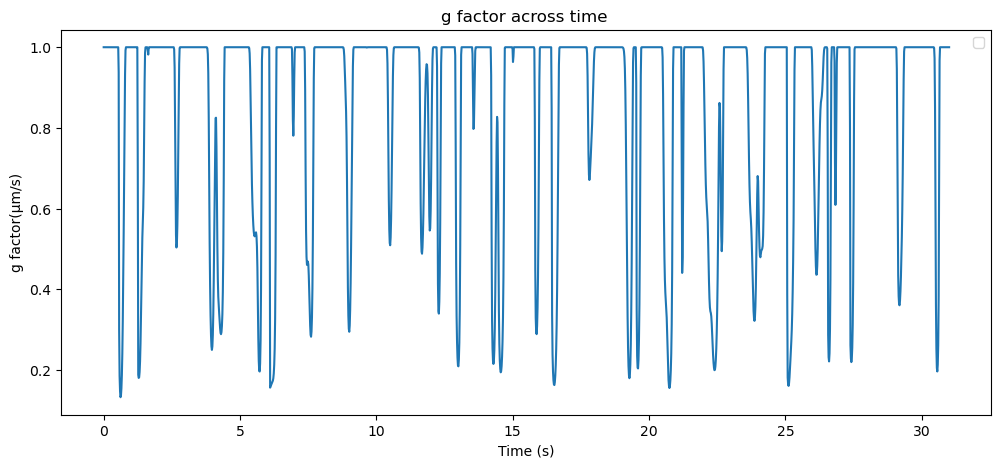

In [116]:
# Lout compare
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 8), sharex=True, sharey=True)
ax1.plot(t_sampling/60, LoutLN, 'k')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Firing Rate (Hz)')
ax1.set_title('Lout',fontsize=20)

ax2.plot(t_sampling/60, LoutGC, 'k')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Firing Rate (Hz)')
ax2.set_title('Lout GC',fontsize=20)

plt.figure(figsize=(12, 5))
plt.plot(t_sampling/60,g)
plt.xlabel('Time (s)')
plt.ylabel('g factor(μm/s)')
plt.title('g factor across time ')
plt.legend()

# spike raster model

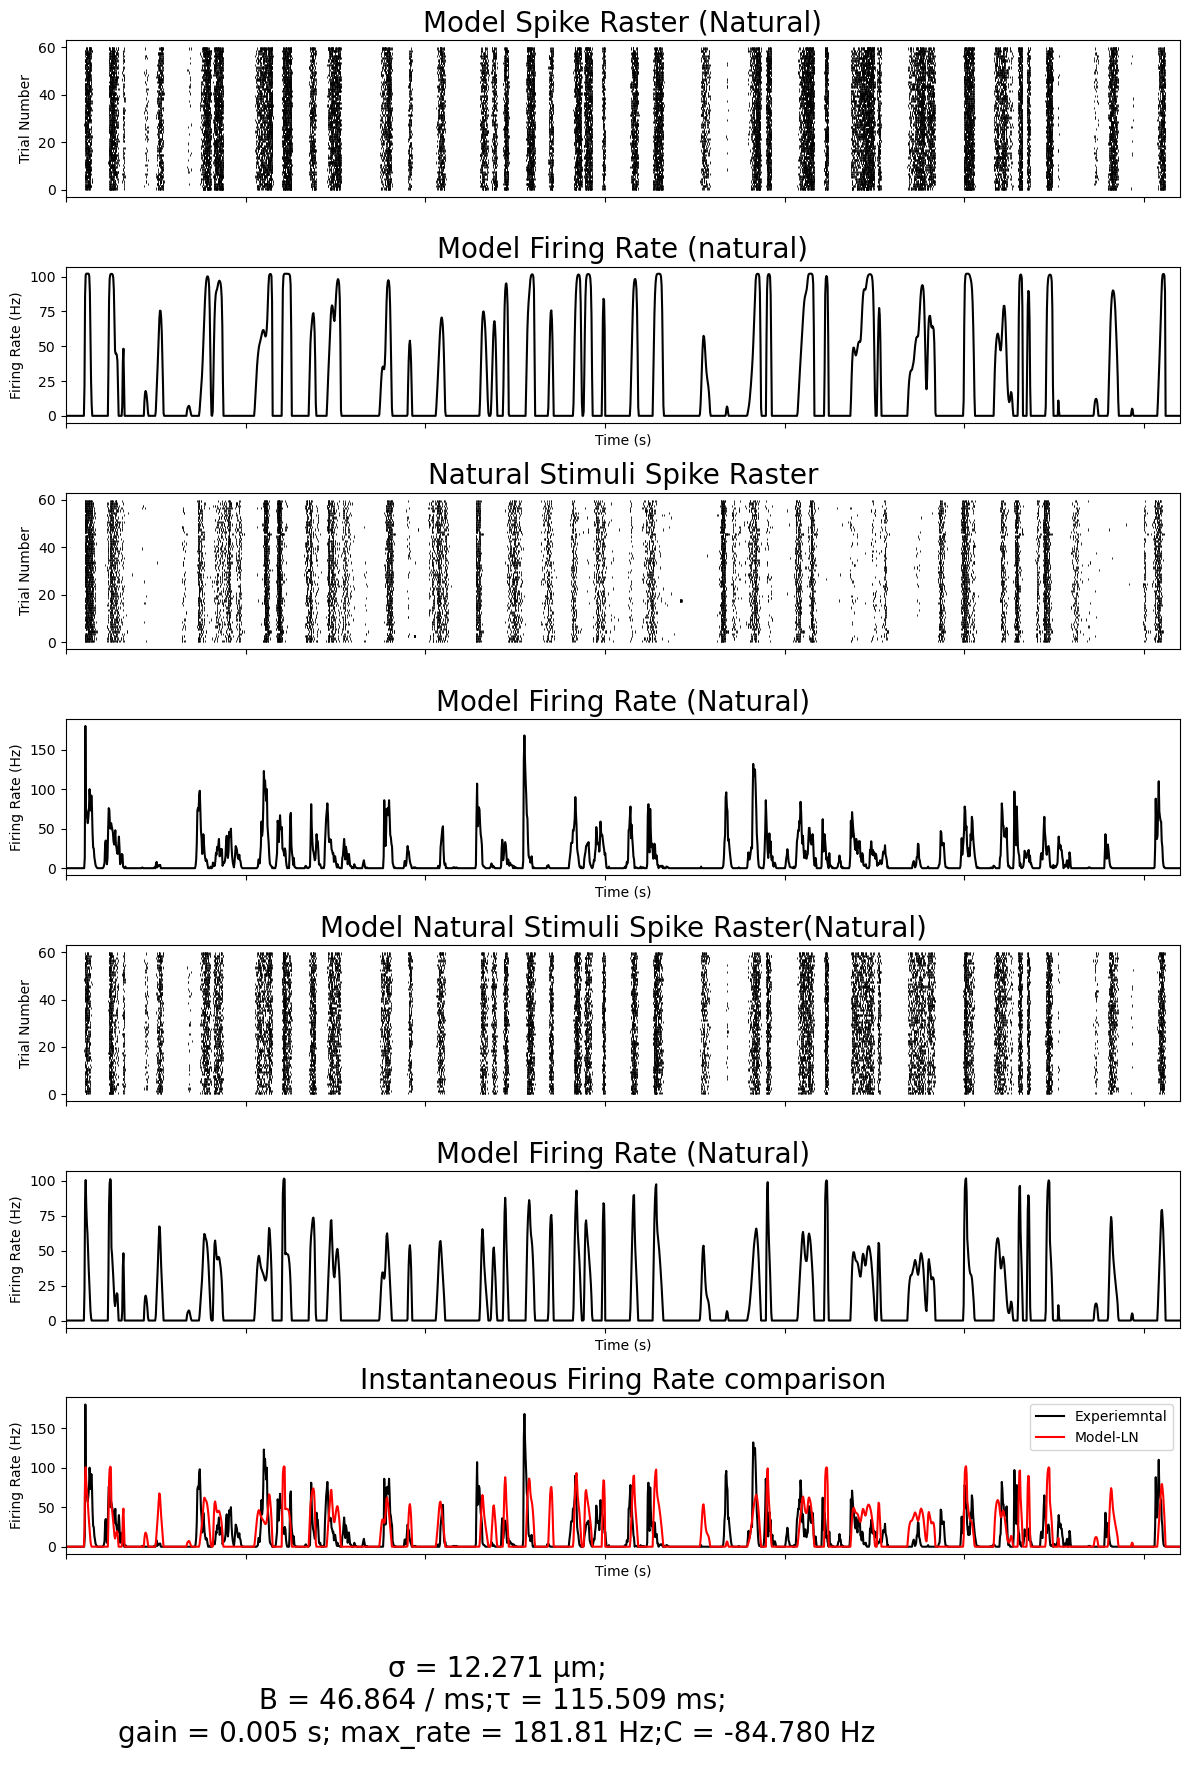

In [117]:
# model for test motion movie
if stimttype == 'movingobject':
    fig, (ax1, ax2, ax3, ax4, ax5,ax6) = plt.subplots(6, 1, figsize=(12, 18), sharex=True)
    spike_t = spike_trainLN
    output_forrating = LNoutLN
    num_trials_modeln = len(spike_t)
    spikes_modeln = []
    for spike_idx_n in range(num_trials_modeln):
        spikes_in_trial = np.array(spike_t[spike_idx_n]) /time_para
        spikes_modeln.extend(spikes_in_trial)
        ax1.vlines(spikes_in_trial, spike_idx_n, spike_idx_n + 1, 'k', linewidth=0.6)

    ax1.set_ylabel('Trial Number')
    ax1.set_title('simulating Natural Stimuli Spike Raster',fontsize = 20)
    ax1.set_xlim(0, 1)  

    ax2.plot(t_sampling/60, output_forrating, 'k')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Firing Rate (Hz)')
    ax2.set_title('Instantaneous Firing Rate Evoked by Natural Stimuli',fontsize = 20)

    for spike_idx_n in range(num_trials_modeln):
        spikes_in_trial = np.array(spike_trainGC[spike_idx_n]) /time_para
        spikes_modeln.extend(spikes_in_trial)
        ax5.vlines(spikes_in_trial, spike_idx_n, spike_idx_n + 1, 'k', linewidth=0.6)

    ax5.set_ylabel('Trial Number')
    ax5.set_title('Simulating Natural Stimuli Spike Raster(Gain Control)',fontsize = 20)
    ax5.set_xlim(0, 1)  

    ax6.plot(t_sampling/60, LNoutGC, 'k')
    ax6.set_xlabel('Time (s)')
    ax6.set_ylabel('Firing Rate (Hz)')
    ax6.set_title('Instantaneous Firing Rate Evoked by Natural Stimuli',fontsize = 20)



    spikes_M = []
    bin_width = 5 * minISI # s
    bins = np.arange(0, 1 + bin_width, bin_width) 
    spikes_in_trial = spike_indices_M[moving_trialidx] / 10000 - delay
    spikes_M.extend(spikes_in_trial)
    counts_M, bin_edges = np.histogram(spikes_M, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    num_trials_M = len(spike_indices_M)



    ax3.vlines(spikes_in_trial, 1, 1 + 1, 'k', linewidth=0.6)
    ax3.set_ylabel('Trial Number')
    ax3.set_title('Natural Stimuli Spike Raster',fontsize = 20)
    ax3.set_xlim(0, 1)  

    average_spike_count_M = counts_M / num_trials_M
    firing_rate_M = average_spike_count_M / bin_width

    ax4.plot(bin_centers, firing_rate_M, 'k')
    ax4.set_xlabel('Time (s)')
    ax4.set_ylabel('Firing Rate (Hz)')
    ax4.set_title('Instantaneous Firing Rate Evoked by Natural Stimuli',fontsize = 20)

    plt.tight_layout()
    plt.show()
else:
    # plot for model and gain control stimuli

    fig, (ax1, ax2, ax3, ax4, ax5,ax6,ax7,ax8) = plt.subplots(8, 1, figsize=(12, 18), sharex=True)

    spike_t = spike_trainLN
    output_forrating = LNoutLN
    num_trials_modeln = len(spike_t)
    spikes_modeln = []
    for spike_idx_n in range(num_trials_modeln):
        spikes_in_trial = np.array(spike_t[spike_idx_n]) /time_para
        spikes_modeln.extend(spikes_in_trial)
        ax1.vlines(spikes_in_trial, spike_idx_n, spike_idx_n + 1, 'k', linewidth=0.6)

    ax1.set_ylabel('Trial Number')
    ax1.set_title('Model Spike Raster (Natural)',fontsize=20)
    ax1.set_xlim(0, 31)  

    ax2.plot(t_sampling/60, output_forrating, 'k')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Firing Rate (Hz)')
    ax2.set_title('Model Firing Rate (natural)',fontsize=20)

    for spike_idx_n in range(num_trials_modeln):
        spikes_in_trial = np.array(spike_trainGC[spike_idx_n]) /time_para
        spikes_modeln.extend(spikes_in_trial)
        ax5.vlines(spikes_in_trial, spike_idx_n, spike_idx_n + 1, 'k', linewidth=0.6)

    ax5.set_ylabel('Trial Number')
    ax5.set_title('Model Natural Stimuli Spike Raster(Natural)',fontsize = 20)
    ax5.set_xlim(0, 31)  

    ax6.plot(t_sampling/60, LNoutGC, 'k')
    ax6.set_xlabel('Time (s)')
    ax6.set_ylabel('Firing Rate (Hz)')
    ax6.set_title('Model Firing Rate (Natural)',fontsize = 20)

    # bin_width = 5 * minISI # s
    bin_width = 1/60 # s
    bins = np.arange(0, 31 + bin_width, bin_width) 
    counts_n, bin_edges = np.histogram(spikes_n, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    num_trials_n = len(spike_indices_n)
    spikes_n = []
    for spike_idx_n in range(num_trials_n):
        spikes_in_trial = spike_indices_n[spike_idx_n] / 10000 - delay
        spikes_n.extend(spikes_in_trial)
        ax3.vlines(spikes_in_trial, spike_idx_n, spike_idx_n + 1, 'k', linewidth=0.6)

    ax3.set_ylabel('Trial Number')
    ax3.set_title('Natural Stimuli Spike Raster',fontsize=20)
    ax3.set_xlim(0, 31)  


    ax4.plot(bin_centers, firing_rate, 'k')
    ax4.set_xlabel('Time (s)')
    ax4.set_ylabel('Firing Rate (Hz)')
    ax4.set_title('Model Firing Rate (Natural)',fontsize = 20)

    ax7.plot(bin_centers, firing_rate, 'k',label='Experiemntal')
    ax7.plot(t_sampling/60, LNoutGC, 'r',label='Model-LN')
    # ax7.plot(t_sampling/60, LNoutLN, 'b',label='Model-LN')
    ax7.set_xlabel('Time (s)')
    ax7.set_ylabel('Firing Rate (Hz)')
    ax7.set_title('Instantaneous Firing Rate comparison',fontsize = 20)
    ax7.legend()
    
# Display parameter summary
    param_text = (
        f"σ = {sigma_x:.3f} µm;\n "

        f"B = {B*60000:.3f} / ms;τ = {tau*16.67:.3f} ms;  \n"
        f"gain = {gain*A:.3f} s; max_rate = {max_rate:.2f} Hz;C = {y/A:.3f} Hz"
    )
    ax8.axis('off')
    ax8.text(12, 0.5, param_text, ha='center', va='center', fontsize=20)
    plt.tight_layout()
    plt.show()




In [118]:
epochD = 1/60 *10000# 1/10000 s
binsSF = np.arange(0, epochD*1861, epochD) 
spikecountsN = []
spikecountsC = []
for i in range(len(spike_indices_n)):
    countstemN, bin_edgesSF = np.histogram(spike_indices_n[i], bins=binsSF)
    countstemC, bin_edgesSF = np.histogram(spike_indices_c[i], bins=binsSF)
    spikecountsN.append(countstemN)
    spikecountsC.append(countstemC)
board_shape = (401,401)
extent = [-200, 200, -200, 200]
sum_responseN = np.zeros(board_shape, dtype=float)
sum_stim_countN = np.zeros(board_shape, dtype=float)
sum_responseC = np.zeros(board_shape, dtype=float)
sum_stim_countC = np.zeros(board_shape, dtype=float)
for trial_spike_counts in spikecountsN:
    num_flashes = len(trial_spike_counts)
    for flash_idx in range(num_flashes):
        if flash_idx < 4:
            continue
        
        group_start = flash_idx 
        stim_frame_idx = group_start - 4
        mask = stimuli_n[stim_frame_idx]
        count = trial_spike_counts[flash_idx]
        sum_responseN += mask * count
        sum_stim_countN += mask

for trial_spike_counts in spikecountsC:
    num_flashes = len(trial_spike_counts)
    for flash_idx in range(num_flashes):
        if flash_idx < 4:
            continue
        
        group_start = flash_idx 
        stim_frame_idx = group_start - 4 
        mask = stimuli_c[stim_frame_idx]
        count = trial_spike_counts[flash_idx]
        sum_responseC += mask * count
        sum_stim_countC += mask



with np.errstate(divide='ignore', invalid='ignore'):
    rfN = np.true_divide(sum_responseN, sum_stim_countN)
    rfN[~np.isfinite(rfN)] = 0
rfN = rfN / np.max(rfN.flatten())
sum_response_plotN = sum_responseN.copy()
sum_response_plotN[sum_response_plotN == 0] = np.nan
sum_stim_count_plotN = sum_stim_countN.copy()
sum_stim_count_plotN[sum_stim_count_plotN == 0] = np.nan
rf_plotN = rfN.copy()
rf_plotN[rf_plotN == 0] = np.nan


with np.errstate(divide='ignore', invalid='ignore'):
    rfC = np.true_divide(sum_responseC, sum_stim_countC)
    rfC[~np.isfinite(rfC)] = 0
rfC = rfC / np.max(rfC.flatten())
sum_response_plotC = sum_responseC.copy()
sum_response_plotC[sum_response_plotC == 0] = np.nan
sum_stim_count_plotC = sum_stim_countC.copy()
sum_stim_count_plotC[sum_stim_count_plotC == 0] = np.nan
rf_plotC = rfC.copy()
rf_plotC[rf_plotC == 0] = np.nan

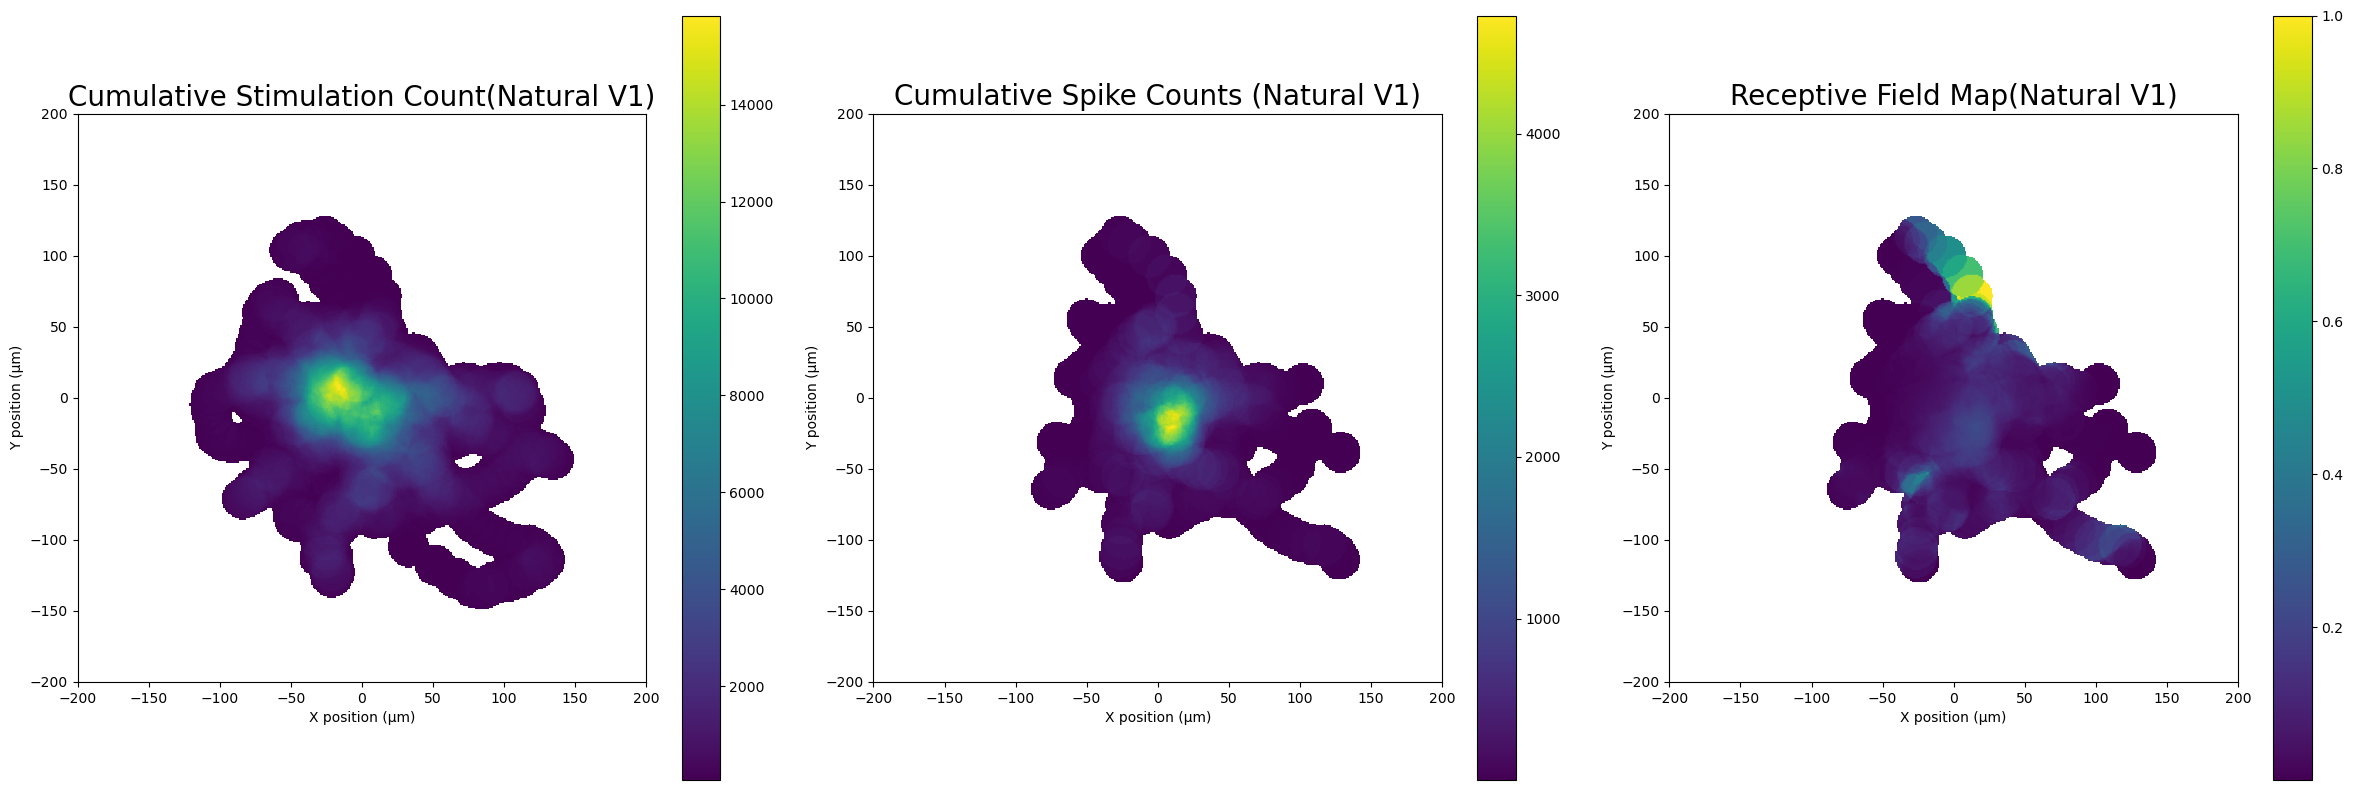

In [119]:
fig, axes = plt.subplots(1, 3, figsize=(24,8))

im0 = axes[0].imshow(sum_stim_count_plotN, extent=extent,origin='lower')
axes[0].set_title('Cumulative Stimulation Count(Natural V1)',fontsize=20)
axes[0].set_xlabel('X position (µm)')
axes[0].set_ylabel('Y position (µm)')
fig.colorbar(im0, ax=axes[0], orientation='vertical')


im1 = axes[1].imshow(sum_response_plotN, extent=extent,origin='lower')
axes[1].set_title('Cumulative Spike Counts (Natural V1)',fontsize=20)
axes[1].set_xlabel('X position (µm)')
axes[1].set_ylabel('Y position (µm)')
fig.colorbar(im1, ax=axes[1], orientation='vertical')

im2 = axes[2].imshow(rf_plotN, extent=extent,origin='lower')
axes[2].set_title('Receptive Field Map(Natural V1)',fontsize=20)
axes[2].set_xlabel('X position (µm)')
axes[2].set_ylabel('Y position (µm)')
fig.colorbar(im2, ax=axes[2], orientation='vertical')

plt.tight_layout()
plt.show()

Calculating RF for 10 trials...
Calculating RF for 20 trials...
Calculating RF for 40 trials...
Calculating RF for 60 trials...


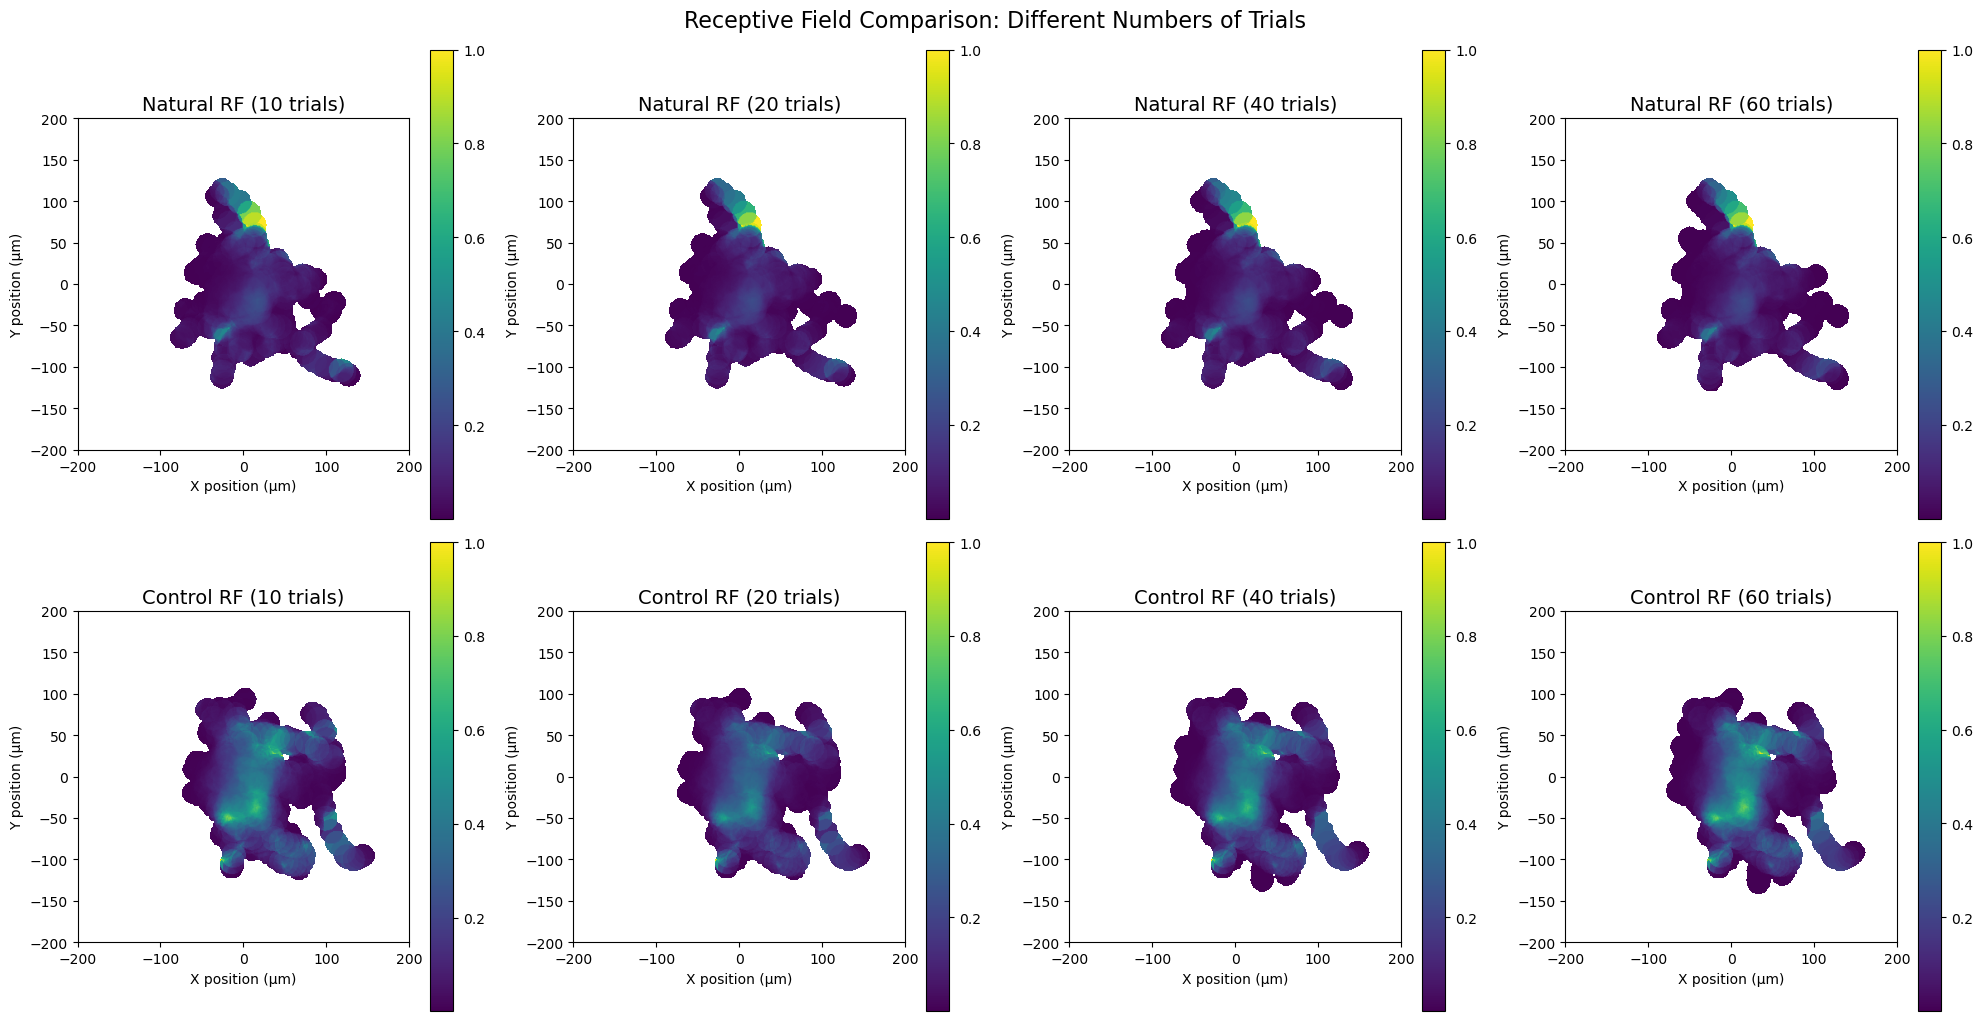

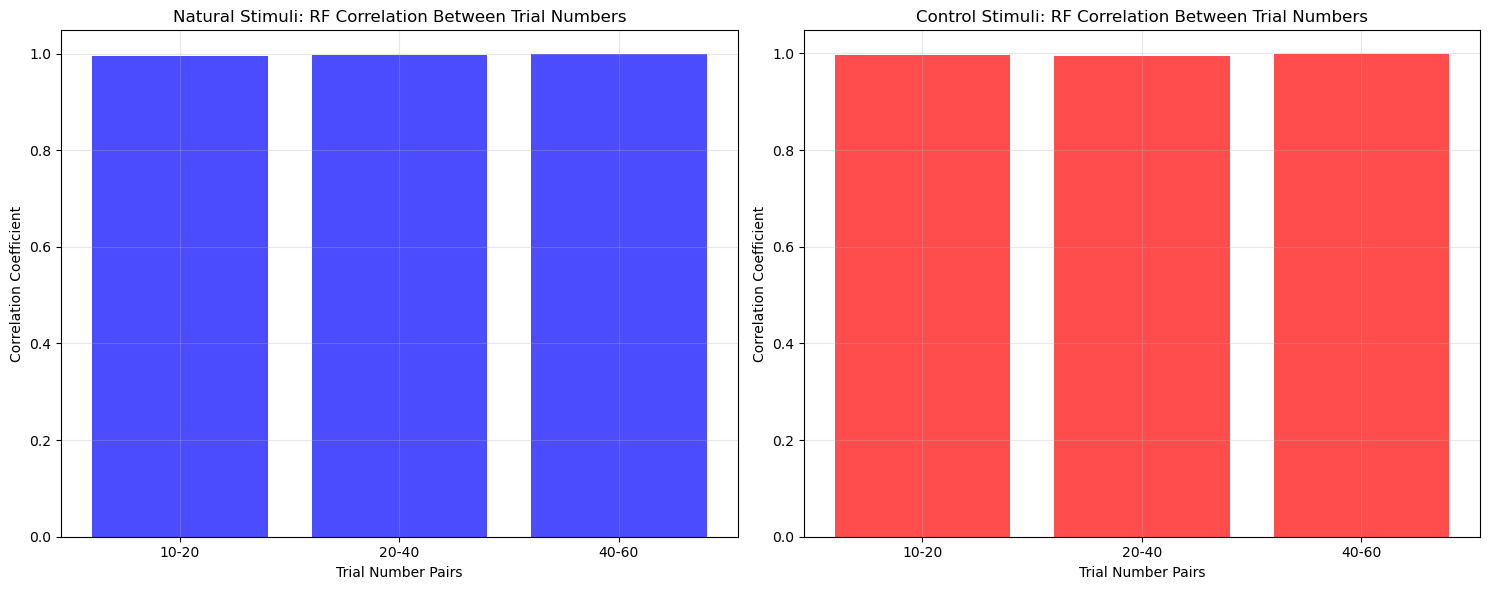

Analysis complete!
Natural stimuli correlations: [0.9946503745867237, 0.9978532858894841, 0.998324295673125]
Control stimuli correlations: [0.9957100079339877, 0.994919821437682, 0.997872786766076]


In [120]:
trial_numbers = [10, 20, 40, 60]

def calculate_rf_for_trials(spike_indices, stimuli, num_trials):
    """Calculate receptive field for a specific number of trials"""
    # Use only the first num_trials
    spike_indices_subset = spike_indices[:num_trials]
    
    # Calculate spike counts
    spikecounts = []
    for i in range(len(spike_indices_subset)):
        countstem, bin_edgesSF = np.histogram(spike_indices_subset[i], bins=binsSF)
        spikecounts.append(countstem)
    
    # Initialize arrays
    sum_response = np.zeros(board_shape, dtype=float)
    sum_stim_count = np.zeros(board_shape, dtype=float)
    
    # Calculate receptive field
    for trial_spike_counts in spikecounts:
        num_flashes = len(trial_spike_counts)
        for flash_idx in range(num_flashes):
            if flash_idx < 4:
                continue
            
            group_start = flash_idx 
            stim_frame_idx = group_start - 4
            mask = stimuli[stim_frame_idx]
            count = trial_spike_counts[flash_idx]
            sum_response += mask * count
            sum_stim_count += mask
    
    # Calculate RF
    with np.errstate(divide='ignore', invalid='ignore'):
        rf = np.true_divide(sum_response, sum_stim_count)
        rf[~np.isfinite(rf)] = 0
    
    # Normalize
    if np.max(rf.flatten()) > 0:
        rf = rf / np.max(rf.flatten())
    
    return rf, sum_response, sum_stim_count

# Calculate RFs for different trial numbers
rf_results_n = {}
rf_results_c = {}

for num_trials in trial_numbers:
    print(f"Calculating RF for {num_trials} trials...")
    
    # Natural stimuli
    rf_n, sum_response_n, sum_stim_count_n = calculate_rf_for_trials(
        spike_indices_n, stimuli_n, num_trials
    )
    rf_results_n[num_trials] = {
        'rf': rf_n,
        'sum_response': sum_response_n,
        'sum_stim_count': sum_stim_count_n
    }
    
    # Control stimuli
    rf_c, sum_response_c, sum_stim_count_c = calculate_rf_for_trials(
        spike_indices_c, stimuli_c, num_trials
    )
    rf_results_c[num_trials] = {
        'rf': rf_c,
        'sum_response': sum_response_c,
        'sum_stim_count': sum_stim_count_c
    }

# Create plots
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# Plot Natural stimuli RFs
for i, num_trials in enumerate(trial_numbers):
    rf_n = rf_results_n[num_trials]['rf']
    rf_plot_n = rf_n.copy()
    rf_plot_n[rf_plot_n == 0] = np.nan
    
    im = axes[0, i].imshow(rf_plot_n, extent=extent, origin='lower', cmap='viridis')
    axes[0, i].set_title(f'Natural RF ({num_trials} trials)', fontsize=14)
    axes[0, i].set_xlabel('X position (µm)')
    axes[0, i].set_ylabel('Y position (µm)')
    plt.colorbar(im, ax=axes[0, i], orientation='vertical')

# Plot Control stimuli RFs
for i, num_trials in enumerate(trial_numbers):
    rf_c = rf_results_c[num_trials]['rf']
    rf_plot_c = rf_c.copy()
    rf_plot_c[rf_plot_c == 0] = np.nan
    
    im = axes[1, i].imshow(rf_plot_c, extent=extent, origin='lower', cmap='viridis')
    axes[1, i].set_title(f'Control RF ({num_trials} trials)', fontsize=14)
    axes[1, i].set_xlabel('X position (µm)')
    axes[1, i].set_ylabel('Y position (µm)')
    plt.colorbar(im, ax=axes[1, i], orientation='vertical')

plt.tight_layout()
plt.suptitle('Receptive Field Comparison: Different Numbers of Trials', fontsize=16, y=1.02)
plt.show()

# Additional plot: Show the progression of RF quality
fig2, axes2 = plt.subplots(1, 2, figsize=(15, 6))

# Calculate correlation between consecutive trial numbers for Natural
correlations_n = []
for i in range(len(trial_numbers)-1):
    rf1 = rf_results_n[trial_numbers[i]]['rf'].flatten()
    rf2 = rf_results_n[trial_numbers[i+1]]['rf'].flatten()
    corr = np.corrcoef(rf1, rf2)[0, 1]
    correlations_n.append(corr)

# Calculate correlation between consecutive trial numbers for Control
correlations_c = []
for i in range(len(trial_numbers)-1):
    rf1 = rf_results_c[trial_numbers[i]]['rf'].flatten()
    rf2 = rf_results_c[trial_numbers[i+1]]['rf'].flatten()
    corr = np.corrcoef(rf1, rf2)[0, 1]
    correlations_c.append(corr)

# Plot correlations
trial_pairs = [f'{trial_numbers[i]}-{trial_numbers[i+1]}' for i in range(len(trial_numbers)-1)]
x_pos = np.arange(len(trial_pairs))

axes2[0].bar(x_pos, correlations_n, color='blue', alpha=0.7)
axes2[0].set_title('Natural Stimuli: RF Correlation Between Trial Numbers')
axes2[0].set_xlabel('Trial Number Pairs')
axes2[0].set_ylabel('Correlation Coefficient')
axes2[0].set_xticks(x_pos)
axes2[0].set_xticklabels(trial_pairs)
axes2[0].grid(True, alpha=0.3)

axes2[1].bar(x_pos, correlations_c, color='red', alpha=0.7)
axes2[1].set_title('Control Stimuli: RF Correlation Between Trial Numbers')
axes2[1].set_xlabel('Trial Number Pairs')
axes2[1].set_ylabel('Correlation Coefficient')
axes2[1].set_xticks(x_pos)
axes2[1].set_xticklabels(trial_pairs)
axes2[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Analysis complete!")
print(f"Natural stimuli correlations: {correlations_n}")
print(f"Control stimuli correlations: {correlations_c}") 

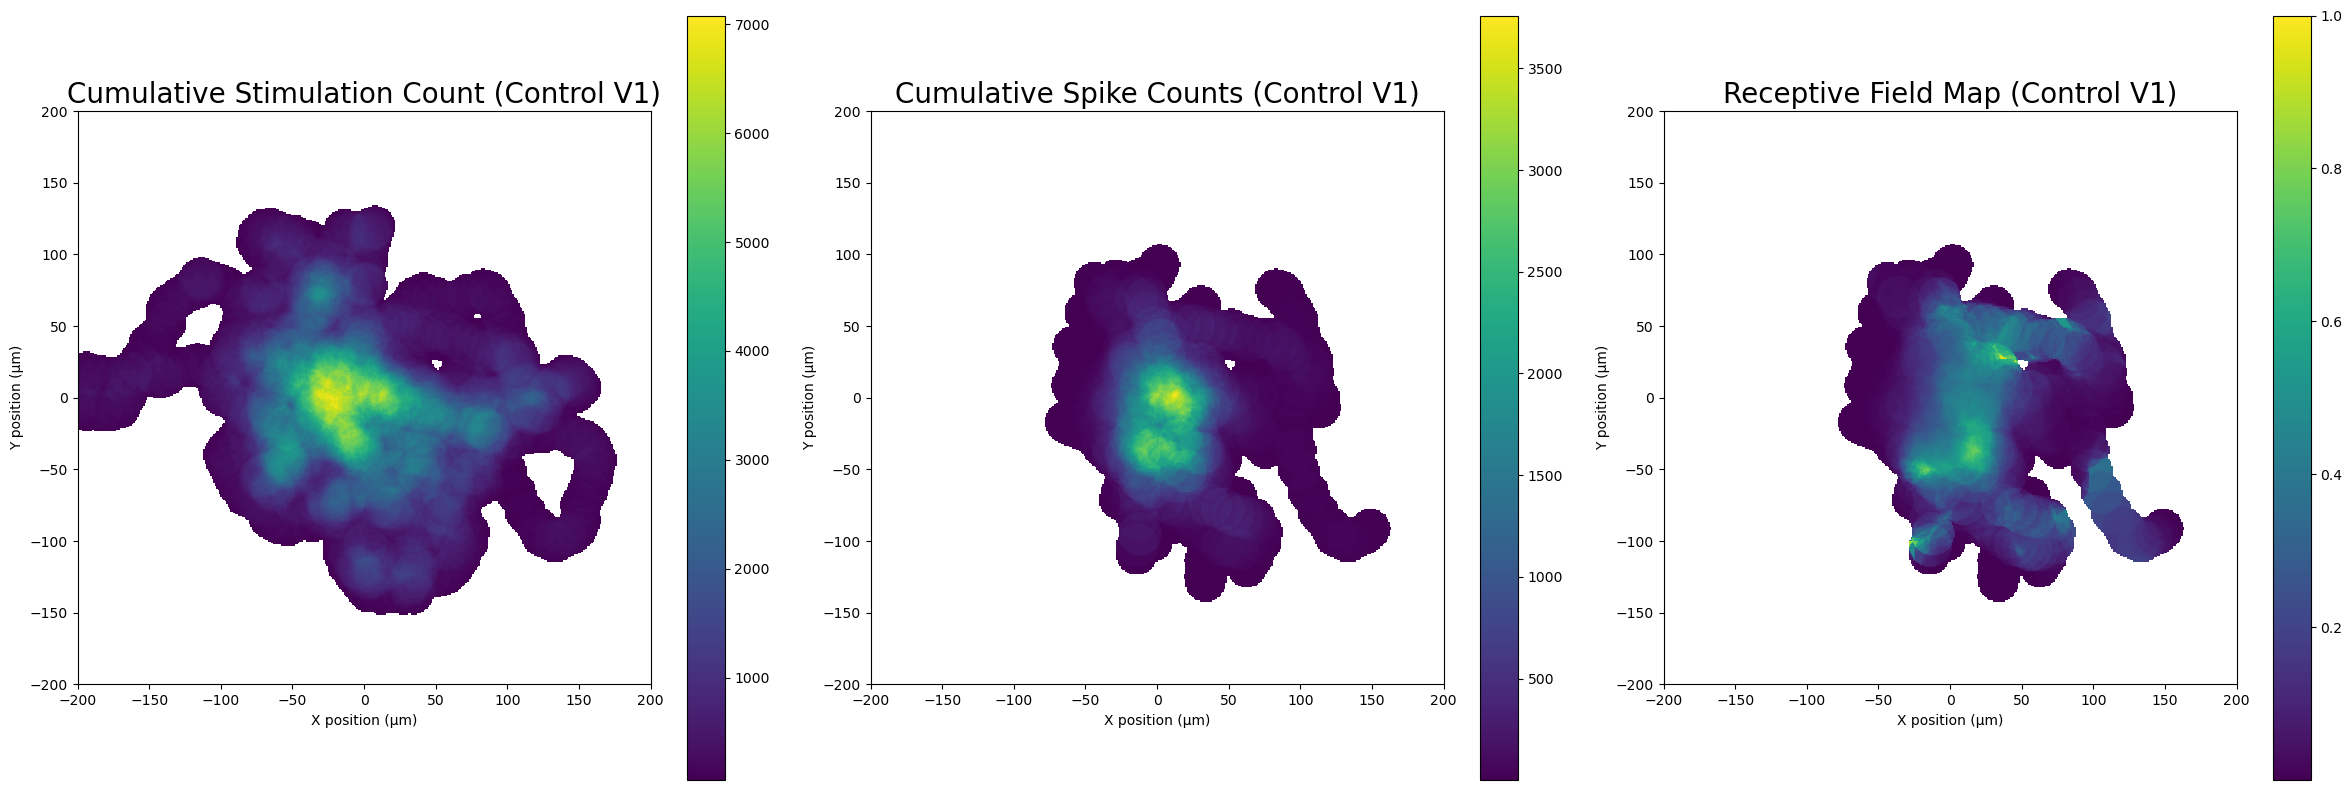

In [121]:
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

im0 = axes[0].imshow(sum_stim_count_plotC, extent=extent,origin='lower')
axes[0].set_title('Cumulative Stimulation Count (Control V1)',fontsize=20)
axes[0].set_xlabel('X position (µm)')
axes[0].set_ylabel('Y position (µm)')
fig.colorbar(im0, ax=axes[0], orientation='vertical')


im1 = axes[1].imshow(sum_response_plotC, extent=extent,origin='lower')
axes[1].set_title('Cumulative Spike Counts (Control V1)',fontsize=20)
axes[1].set_xlabel('X position (µm)')
axes[1].set_ylabel('Y position (µm)')
fig.colorbar(im1, ax=axes[1], orientation='vertical')

im2 = axes[2].imshow(rf_plotC, extent=extent,origin='lower')
axes[2].set_title('Receptive Field Map (Control V1)',fontsize=20)
axes[2].set_xlabel('X position (µm)')
axes[2].set_ylabel('Y position (µm)')
fig.colorbar(im2, ax=axes[2], orientation='vertical')

plt.tight_layout()
plt.show()

# ROI distribution of varxy

In [122]:
idx_higherbool = LNoutGC > firing_rate
idx_lowerbool = LNoutGC < firing_rate
tolerance = 0.3
idx_samebool = np.abs(LNoutGC - firing_rate)/ firing_rate <= tolerance
region = np.zeros_like(bin_centers, dtype=int)
region[idx_higherbool] = +1
region[idx_lowerbool]  = -1
region[idx_samebool]   =  0  

def group_by_region(x, region_array):
    if len(x) == 0:
        return
    start_idx = 0
    current_val = region_array[0]
    n = len(x)
    for i in range(1, n):
        if region_array[i] != current_val:
            # The segment [start_idx, i-1] had constant region current_val
            yield current_val, x[start_idx], x[i-1]
            start_idx = i
            current_val = region_array[i]
    # Last segment
    yield current_val, x[start_idx], x[n-1]


C:\Users\Komeijiiiii\AppData\Local\Temp\ipykernel_36644\1430049324.py:4: RuntimeWarning: divide by zero encountered in divide
  idx_samebool = np.abs(LNoutGC - firing_rate)/ firing_rate <= tolerance
C:\Users\Komeijiiiii\AppData\Local\Temp\ipykernel_36644\1430049324.py:4: RuntimeWarning: invalid value encountered in divide
  idx_samebool = np.abs(LNoutGC - firing_rate)/ firing_rate <= tolerance


C:\Users\Komeijiiiii\AppData\Local\Temp\ipykernel_36644\4187636241.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


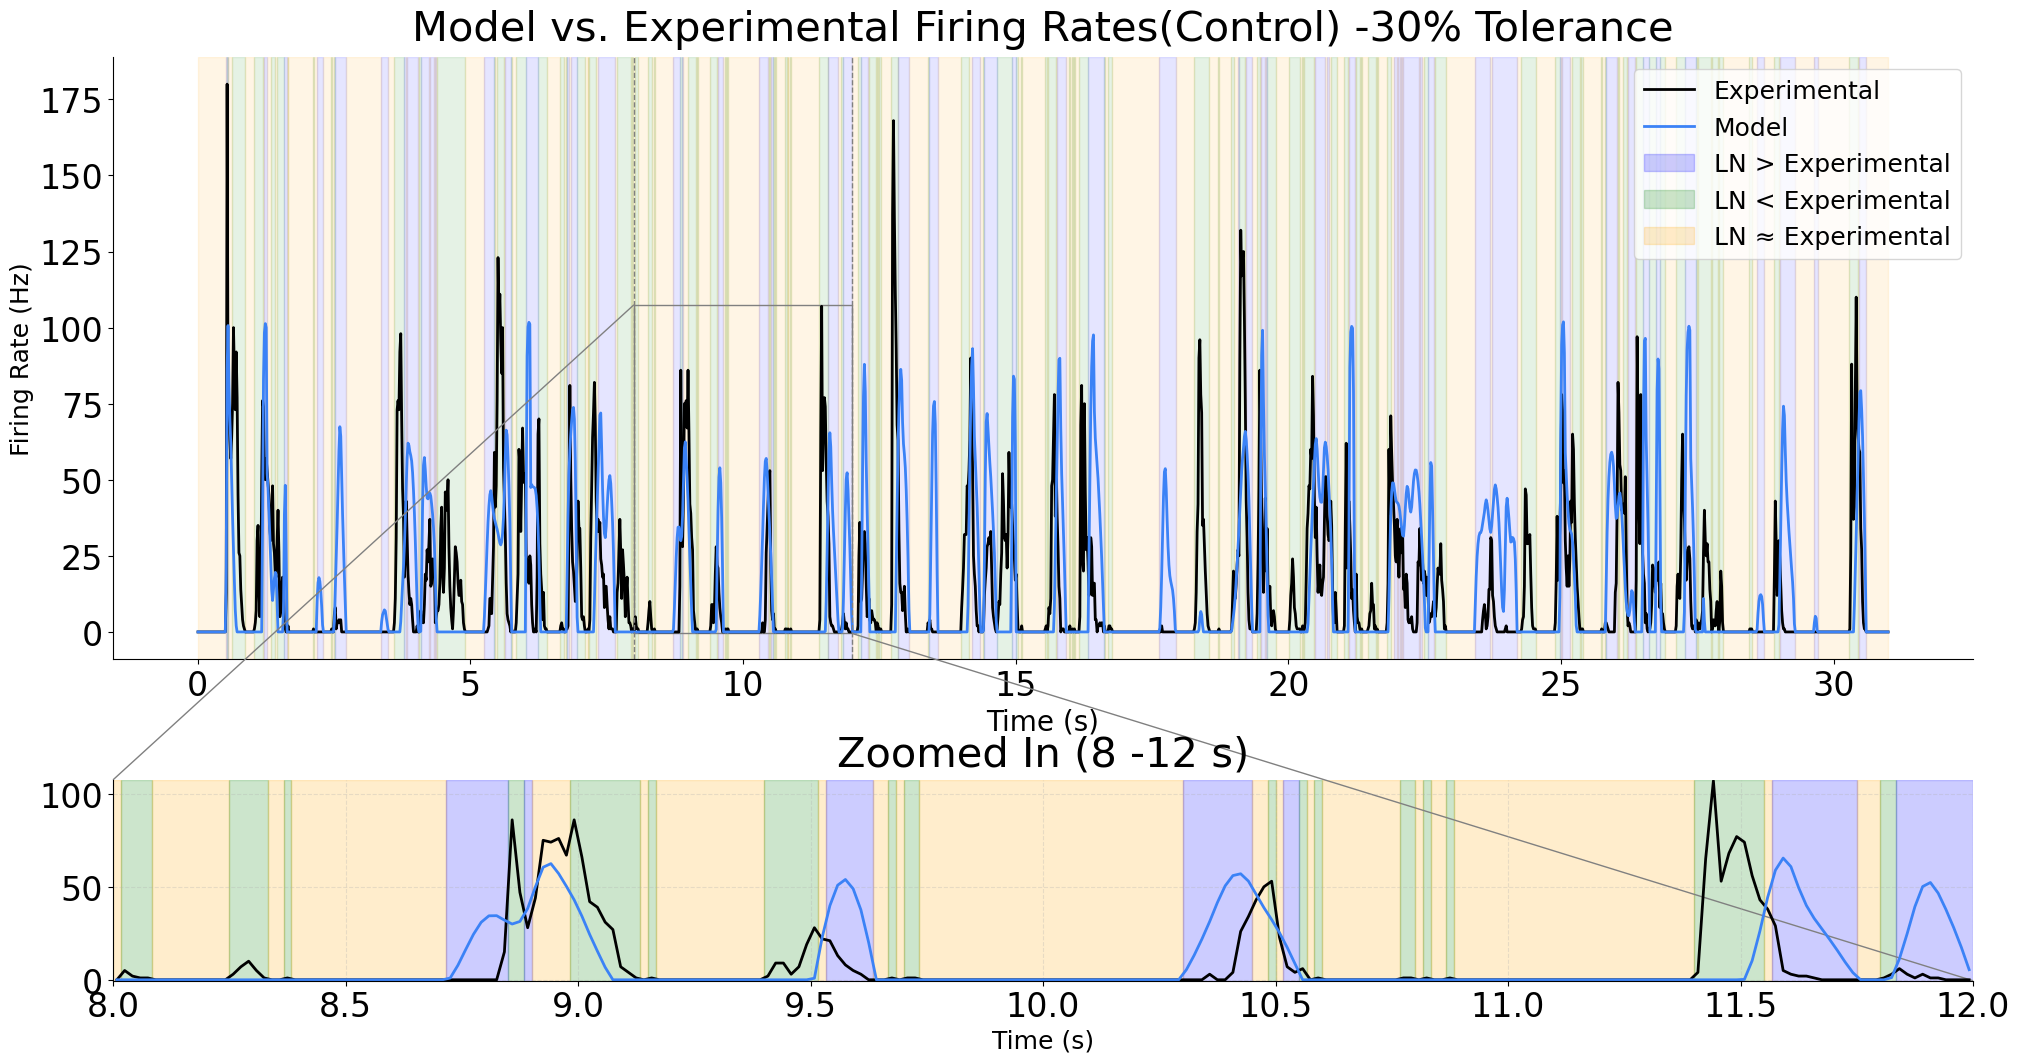

In [123]:
# zoom limits
x1, x2 = 8,12

color_map = {+1:'blue', 0:'orange', -1:'green'}

dx = bin_centers[1] - bin_centers[0]
half_dx = dx/2

fig = plt.figure(figsize=(24,12))
gs  = GridSpec(2, 1, height_ratios=[3,1], hspace=0.3)
ax_main = fig.add_subplot(gs[0])
ax_zoom = fig.add_subplot(gs[1])

# ---- Main panel ----
ax_main.plot(bin_centers, firing_rate, color='black', lw=2, label='Experimental')
ax_main.plot(bin_centers, LNoutGC,     color='#3B82F6',   lw=2, label='Model')

# shading with half-bin extension
for val, start, end in group_by_region(bin_centers, region):
    ax_main.axvspan(start - half_dx, end + half_dx,
                    color=color_map[val], alpha=0.1)

# mark zoom region
ax_main.axvline(x1, color='gray', linestyle='--', lw=1)
ax_main.axvline(x2, color='gray', linestyle='--', lw=1)

ax_main.set_title(

    "Model vs. Experimental Firing Rates(Control) -30% Tolerance",
    fontsize=30, pad=12
)
ax_main.set_xlabel('Time (s)', fontsize=20)
ax_main.set_ylabel('Firing Rate (Hz)', fontsize=18)


patches = [
    mpatches.Patch(color='blue',  alpha=0.2, label='LN > Experimental'),
    mpatches.Patch(color='green', alpha=0.2, label='LN < Experimental'),
    mpatches.Patch(color='orange',alpha=0.2, label='LN ≈ Experimental'),
]
h, l = ax_main.get_legend_handles_labels()
h.extend(patches); l.extend([p.get_label() for p in patches])
ax_main.legend(h, l, loc='upper right', fontsize=18)
for spine in ('top','right'):
    ax_main.spines[spine].set_visible(False)
ax_main.tick_params(axis='both', which='major', labelsize=24)
# ---- Zoom panel ----
# same shading but clipped to [x1,x2]
for val, start, end in group_by_region(bin_centers, region):
    seg_start = max(start - half_dx, x1)
    seg_end   = min(end   + half_dx, x2)
    if seg_end > seg_start:
        ax_zoom.axvspan(seg_start, seg_end,
                        color=color_map[val], alpha=0.2)

mask = (bin_centers >= x1) & (bin_centers <= x2)
ax_zoom.plot(bin_centers[mask], firing_rate[mask], color='black', lw=2)
ax_zoom.plot(bin_centers[mask], LNoutGC[mask],     color='#3B82F6',   lw=2)

ax_zoom.set_xlim(x1, x2)
ymin = firing_rate[mask].min()
ymax = firing_rate[mask].max()
ymin = min(ymin, LNoutGC[mask].min()) - 0.5
ymax = max(ymax, LNoutGC[mask].max()) + 0.5
ax_zoom.set_ylim(ymin, ymax)

ax_zoom.set_title('Zoomed In (8 -12 s)', fontsize=30, pad=10)
ax_zoom.set_xlabel('Time (s)', fontsize=18)

for spine in ('top','right'):
    ax_zoom.spines[spine].set_visible(False)
ax_zoom.grid(True, linestyle='--', alpha=0.3)
ax_zoom.tick_params(axis='both', which='major', labelsize=24)
# connectors
mark_inset(ax_main, ax_zoom, loc1=2, loc2=4, fc='none', ec='gray', lw=1)


plt.tight_layout()
plt.show()

C:\Users\Komeijiiiii\AppData\Local\Temp\ipykernel_36644\2521812779.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('bwr').copy()


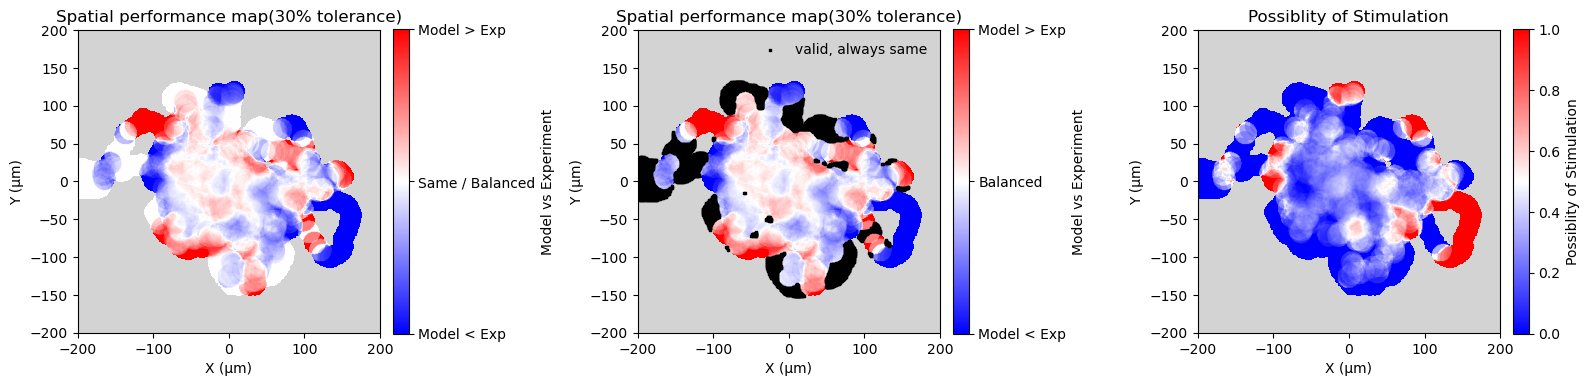

In [124]:
board_size = 400
diameter = 30
rf_blank = rf_estimated.copy()
blank_mask = (rf_estimated == 0)
rf_blank[blank_mask] = np.nan
# Build spatial grid
board_range = [-(board_size/2), board_size/2]
x_vals = np.linspace(board_range[0], board_range[1], board_size+1)
y_vals = np.linspace(board_range[0], board_range[1], board_size+1)
X, Y = np.meshgrid(x_vals, y_vals)
radius = diameter / 2

# Prepare accumulator arrays
visit_count = np.zeros_like(X, dtype=int)
score_accum = np.zeros_like(X, dtype=float)
pos_count = np.zeros_like(visit_count)
neg_count = np.zeros_like(visit_count)
# Loop over time bins
for t in range(len(region)-4):
    x_c = trajx[0][t]
    y_c = trajy[0][t]
    mask = (X - x_c)**2 + (Y - y_c)**2 <= radius**2
    visit_count[mask] += 1
    score_accum[mask] += region[t+4]
    pos_count[mask] += (region[t+4] == +1)
    neg_count[mask] += (region[t+4] == -1)

# Compute mean score map (avoid divide by zero)
mean_score = np.full_like(score_accum, np.nan, dtype=float)
valid = visit_count > 0
mean_score[valid] = score_accum[valid] / visit_count[valid]
mean_score_ma = np.ma.array(mean_score, mask=np.isnan(mean_score))
always_zero_mask = valid & (pos_count == 0) & (neg_count == 0)


possiblity_map = np.full_like(score_accum, np.nan, dtype=float)
possiblity_map[valid] = neg_count[valid] / visit_count[valid]

# Prepare colormap: blue-white-red with NaNs shown in light gray
cmap = plt.cm.get_cmap('bwr').copy()
cmap.set_bad(color='lightgray')
# Display spatial performance map
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 10))

im1 = ax1.imshow(mean_score_ma, origin='lower',
                extent=[board_range[0], board_range[1],
                        board_range[0], board_range[1]],
                cmap=cmap, vmin=-1, vmax=1)
cb1 = fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
cb1.set_ticks([-1, 0, 1])
cb1.set_ticklabels(['Model < Exp', 'Same / Balanced', 'Model > Exp'])
cb1.set_label('Model vs Experiment')
ax1.set_title('Spatial performance map(30% tolerance)')
ax1.set_xlabel('X (µm)')
ax1.set_ylabel('Y (µm)')

im3 = ax3.imshow(possiblity_map, origin='lower',
                extent=[board_range[0], board_range[1],
                        board_range[0], board_range[1]],
                cmap=cmap, vmin=0, vmax=1)
cb3 = fig.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04)
cb3.set_label('Possiblity of Stimulation')

ax3.set_title('Possiblity of Stimulation')
ax3.set_xlabel('X (µm)')
ax3.set_ylabel('Y (µm)')


im2 = ax2.imshow(mean_score_ma, origin='lower',
               extent=[board_range[0], board_range[1],
                       board_range[0], board_range[1]],
               cmap=cmap, vmin=-1, vmax=1)
cb2 = fig.colorbar(im1, ax=ax2, fraction=0.046, pad=0.04)
cb2.set_ticks([-1, 0, 1])
cb2.set_ticklabels(['Model < Exp', 'Balanced', 'Model > Exp'])
cb2.set_label('Model vs Experiment')

# 5) Overlay pixels always zero with a subtle hatch or marker
ys, xs = np.where(always_zero_mask)
ax2.scatter(x_vals[xs], y_vals[ys], s=2, c='black', 
          marker='s', label='valid, always same')

# 2inal formatting
ax2.set_title('Spatial performance map(30% tolerance)')
ax2.set_xlabel('X (µm)')
ax2.set_ylabel('Y (µm)')
ax2.legend(loc='upper right', frameon=False)




plt.tight_layout()
plt.show()

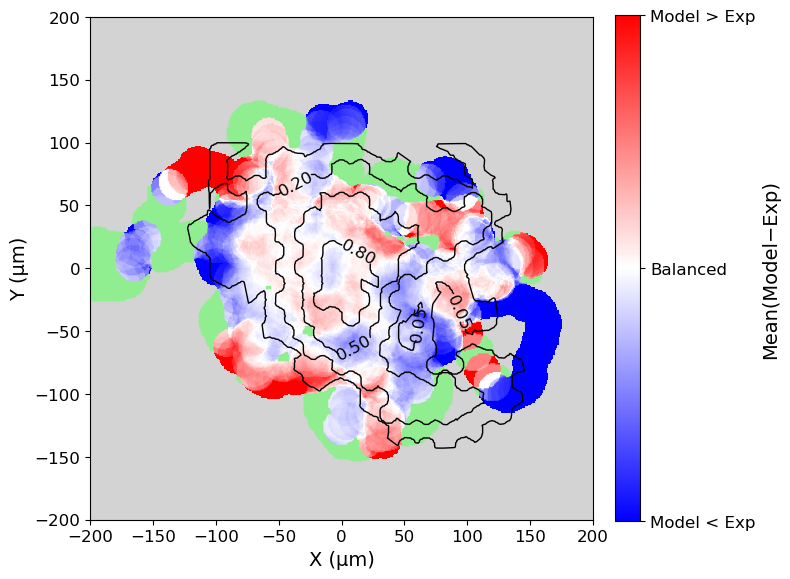

In [125]:

Xg, Yg = np.meshgrid(x_vals, y_vals)

fig, ax = plt.subplots(figsize=(8,8))

im = ax.imshow(mean_score_ma, origin='lower',
               extent=[board_range[0], board_range[1],
                       board_range[0], board_range[1]],
               cmap=cmap, vmin=-1, vmax=1)

# 5) Overlay pixels always zero with a subtle hatch or marker
ys, xs = np.where(always_zero_mask)
ax.scatter(x_vals[xs], y_vals[ys], s=2, c='lightgreen', 
           marker='s', label='valid, always same')


# Overlay RF contour lines
cs = ax.contour(Xg, Yg, rf_estimated, levels=[0.05*np.nanmax(rf_estimated),
                                              0.2*np.nanmax(rf_estimated),
                                              0.5*np.nanmax(rf_estimated),
                                              0.8*np.nanmax(rf_estimated),
                                              ],colors='k', linewidths=1,alpha=1)
ax.clabel(cs, inline=1, fmt='%.2f', fontsize=12)

# Colorbar for performance
cb = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cb.set_ticks([-1, 0, 1])
cb.set_ticklabels(['Model < Exp','Balanced','Model > Exp'], fontsize=12)
cb.set_label('Mean(Model−Exp)', fontsize=14)

# ax.set_title('Performance Map',fontsize=20)
ax.set_xlabel('X (µm)', fontsize=14)
ax.set_ylabel('Y (µm)', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()


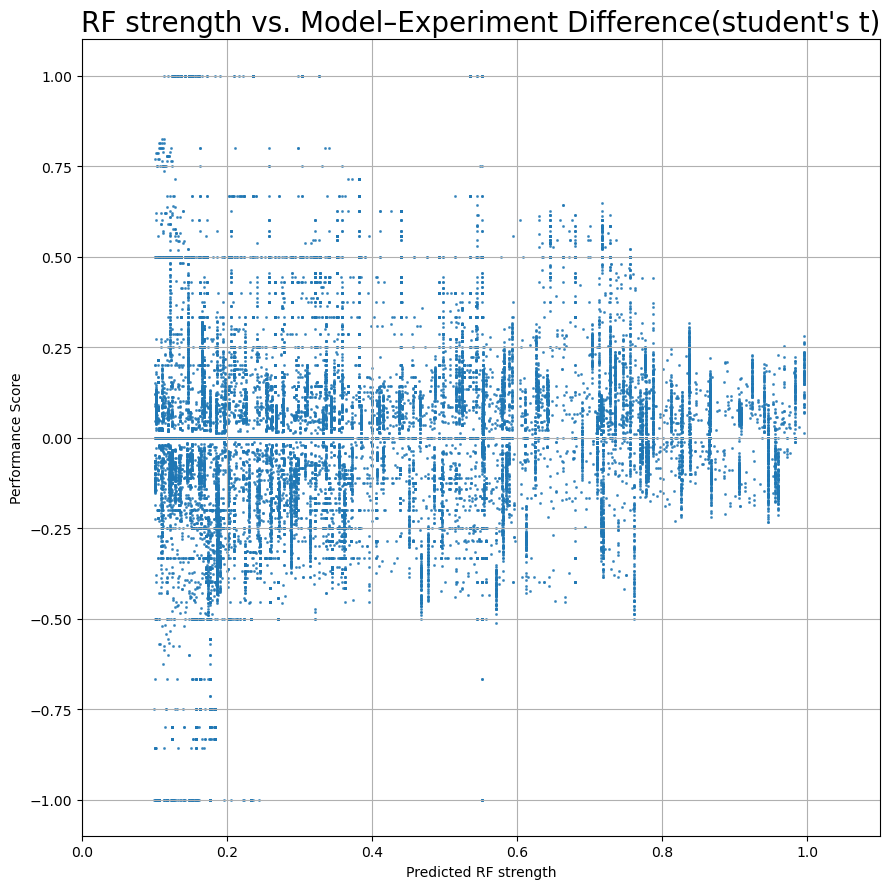

In [126]:

rf_flat = rf_estimated.flatten()
score_flat = mean_score.flatten()
visited_flat = (visit_count.flatten() > 0)

x = rf_flat[visited_flat]
y = score_flat[visited_flat]
threshold = 0.1
mask = x > threshold
x_filt = x[mask]
y_filt = y[mask]
# Scatter plot
plt.figure(figsize=(9,9))
plt.scatter(x_filt, y_filt, marker='.', s=5, alpha=0.7)
plt.xlim(0, 1.1)
plt.ylim(-1.1, 1.1)
plt.xlabel('Predicted RF strength')
plt.ylabel('Performance Score')
plt.title('RF strength vs. Model–Experiment Difference(student\'s t)',fontsize=20)
plt.grid(True)
plt.tight_layout()
plt.show()


In [127]:

ticks_per_bin = time_para * dt  # number of ticks per bin (90)

# Prepare lists to store spike times based on region
spikesn_high = []   # spikes in bins where LNoutGC > firing_rate
spikesn_low = []    # spikes in bins where LNoutGC < firing_rate
spikesn_same = []   # spikes in bins where LNoutGC ~ firing_rate

# Iterate over each trial's spike train
for trial in spike_trainGC:
    trial_spikes = trial[0] 
    trial_high = []  
    trial_low = []  
    trial_same = []  

    for spike_time in trial_spikes:
        # Determine the bin index for the spike:
        bin_idx = int(spike_time / ticks_per_bin)
        # Process only if bin_idx is within the region array range
        if bin_idx < len(region):
            if region[bin_idx] == 1:
                trial_high.append(spike_time)
            elif region[bin_idx] == -1:
                trial_low.append(spike_time)
            elif region[bin_idx] == 0:
                trial_same.append(spike_time)
    spikesn_high.append((np.array(trial_high),))
    spikesn_low.append((np.array(trial_low),))
    spikesn_same.append((np.array(trial_same),))

spikesn_real = []
for trial in spike_indices_n:
    spikesn_real.append((np.array(trial),))


In [128]:
trajn_feature = all_vn, all_an, all_r_n, trajx_n, trajy_n, dt, time_para
trajc_feature = all_vc, all_ac, all_r_c, trajx_c, trajy_c, dt, time_para

In [129]:

region_v = region[:-1]      # for v (velocity)
region_a = region[1:-1]      # for a (acceleration)


# Extract values for each region:
def extract_region_values(region_labels, data_array, region_value):
    return data_array[region_labels == region_value]

# Extract for position (x, y), and radius (r)
x_high = extract_region_values(region, trajx[0], 1)
y_high = extract_region_values(region, trajy[0], 1)
r_high = extract_region_values(region, all_r[0], 1)
x_low = extract_region_values(region, trajx[0], -1)
y_low = extract_region_values(region, trajy[0], -1)
r_low = extract_region_values(region, all_r[0], -1)
x_same = extract_region_values(region, trajx[0], 0)
y_same = extract_region_values(region, trajy[0], 0)
r_same = extract_region_values(region, all_r[0], 0)
# Extract for velocity (v)
v_high = extract_region_values(region_v, all_v[0], 1)
v_low = extract_region_values(region_v, all_v[0], -1)
v_same = extract_region_values(region_v, all_v[0], 0)
# Extract for acceleration (a)
a_high = extract_region_values(region_a, all_a[0], 1)
a_low = extract_region_values(region_a, all_a[0], -1)
a_same = extract_region_values(region_a, all_a[0], 0)

# Plot histograms to compare original vs regions:
variables = ['Velocity (μm/s)', 'Acceleration (μm/s²)', 'Position X (μm)', 'Position Y (μm)', 'Radius (μm)']
x_labels = ['Velocity (μm/s)', 'Acceleration (μm/s²)', 'Position X (μm)', 'Position Y (μm)', 'Radius (μm)']
y_labels = ['Normalized Density'] * 5
all_data = [all_v[0], all_a[0], trajx[0], trajy[0], all_r[0]]
high_data = [v_high, a_high, x_high, y_high, r_high]
low_data = [v_low, a_low, x_low, y_low, r_low]
same_data = [v_same, a_same, x_same, y_same, r_same]

def get_hist_line(data, bins=100, density=True):
    counts, bin_edges = np.histogram(data, bins=bins, density=density)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    return bin_centers, counts
def compute_statistics(data):
    mean_val = np.mean(data)
    median_val = np.median(data)
    std_val = np.std(data)
    skew_val = stats.skew(data)
    kurt_val = stats.kurtosis(data)
    return [mean_val, median_val, std_val, skew_val, kurt_val]


data_categories = {
    'Original': all_data,
    'Model > Real': high_data,
    'Model < Real': low_data,
    'Same': same_data
}


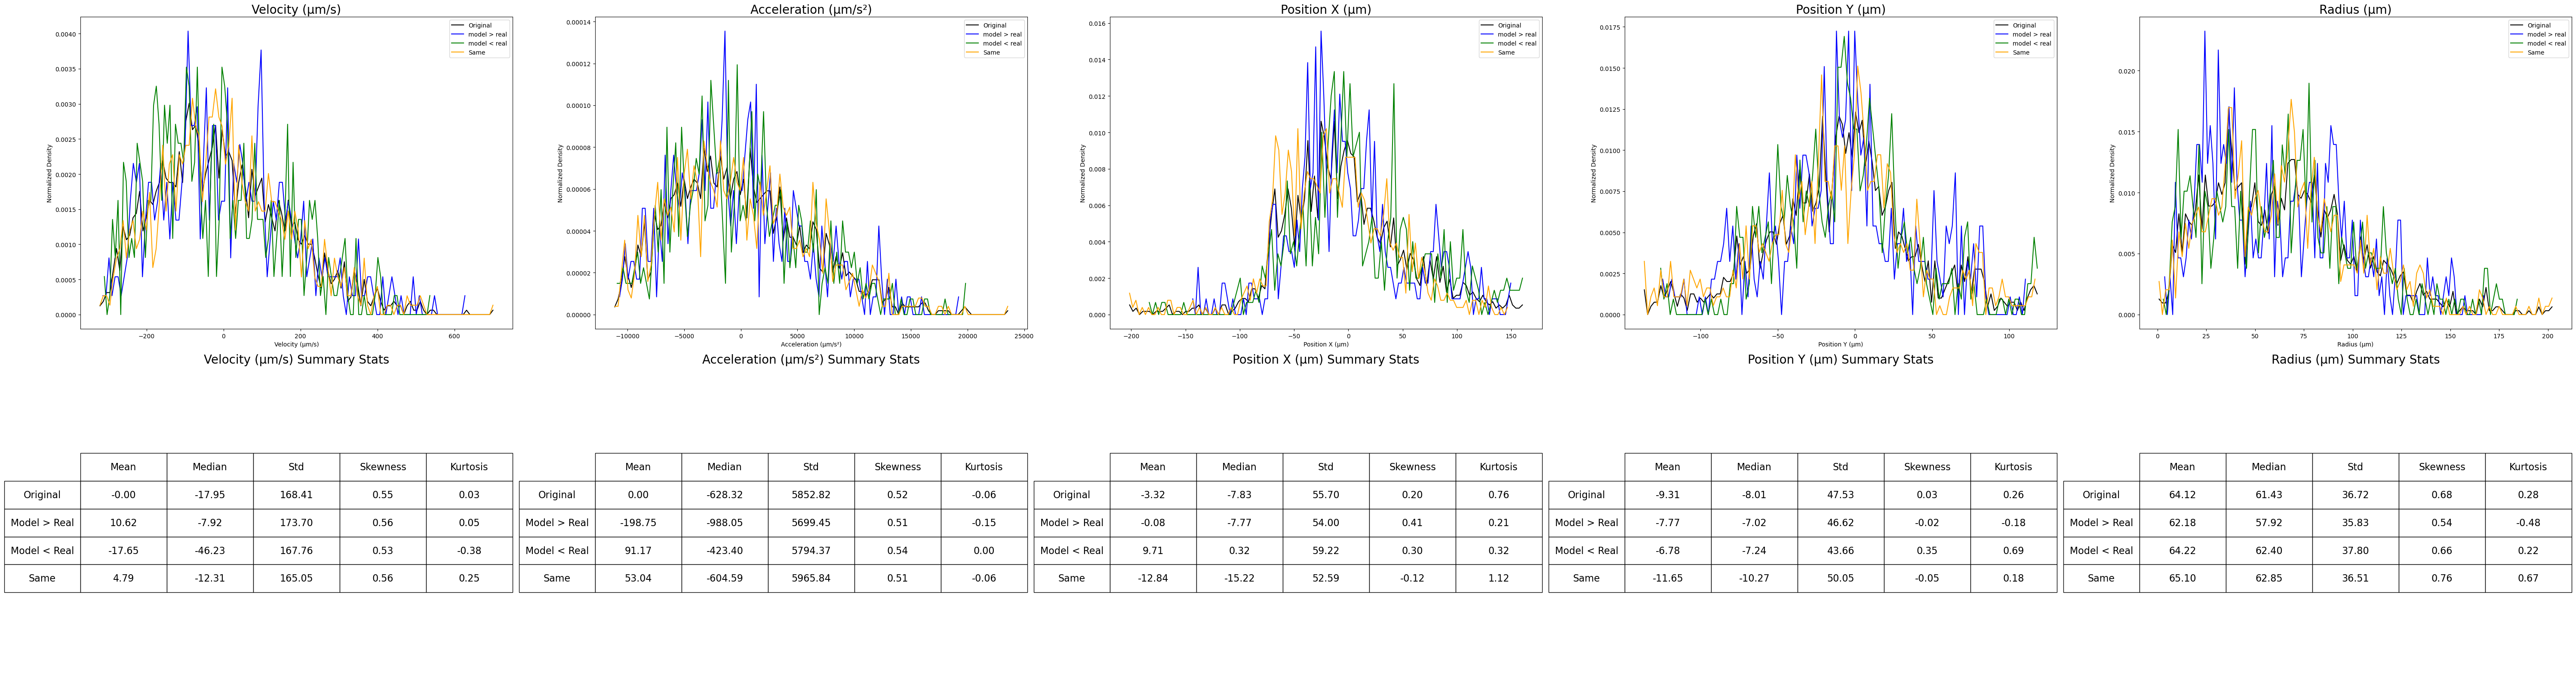

In [130]:

# Create a figure with 2 rows (top for histograms, bottom for tables) and 5 columns (one for each variable)
fig, axes = plt.subplots(2, 5, figsize=(60, 16))
bins = 120
if stimttype == 'natural':
    fig.suptitle("Distribution Comparison and Summary Statistics (Natural)", fontsize=30, y=0.97)
if stimttype == 'control':
    fig.suptitle("Distribution Comparison and Summary Statistics (Control)", fontsize=30, y=0.97)
# Top row: Plot histograms for each variable
for i in range(5):
    ax = axes[0, i]
    # Original data histogram
    x_all, y_all = get_hist_line(all_data[i], bins)
    ax.plot(x_all, y_all, label='Original', color='black')
    # High region histogram
    x_high_vals, y_high_vals = get_hist_line(high_data[i], bins)
    ax.plot(x_high_vals, y_high_vals, label='model > real', color='blue')
    # Low region histogram
    x_low_vals, y_low_vals = get_hist_line(low_data[i], bins)
    ax.plot(x_low_vals, y_low_vals, label='model < real', color='green')
    # Same region histogram
    x_same_vals, y_same_vals = get_hist_line(same_data[i], bins)
    ax.plot(x_same_vals, y_same_vals, label='Same', color='orange')
    
    ax.set_title(variables[i],fontsize=20)
    ax.set_xlabel(x_labels[i])
    ax.set_ylabel(y_labels[i])
    ax.legend()

# Bottom row: Create a table of summary statistics for each variable
# Define column labels for the table
col_labels = ['Mean', 'Median', 'Std', 'Skewness', 'Kurtosis']
row_labels = list(data_categories.keys())
table_height = 3  # Adjust table height as needed.

for i in range(5):
    ax_table = axes[1, i]
    ax_table.axis('off')
    stats_data = []
    for r in row_labels:
        stats_vals = compute_statistics(data_categories[r][i])

        stats_data.append([f"{val:.2f}" for val in stats_vals])
    df = pd.DataFrame(stats_data, index=row_labels, columns=col_labels)
    table = ax_table.table(cellText=df.values,
                           rowLabels=df.index,
                           colLabels=df.columns,
                           cellLoc='center',
                           rowLoc='center',
                           loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(16)
    table.scale(1, table_height)  # Scale table height
    ax_table.set_title(f"{variables[i]} Summary Stats", fontsize=20)
plt.tight_layout()
plt.show()


In [131]:

STA_high = sg.STA(T, spikesn_high, traj_feature)
STA_low = sg.STA(T, spikesn_low, traj_feature)
STA_same = sg.STA(T, spikesn_same, traj_feature)
if 'natural' in stimttype:
    STA_real = time_window, avg_sta_v_n, avg_sta_a_n, avg_sta_x_n, avg_sta_y_n, avg_sta_r_n, sem_x_n, sem_y_n, sem_r_n, sem_v_n, sem_a_n
if 'control' in stimttype:
    STA_real = time_window, avg_sta_v_c, avg_sta_a_c, avg_sta_x_c, avg_sta_y_c, avg_sta_r_c, sem_x_c, sem_y_c, sem_r_c, sem_v_c, sem_a_c


d:\OneDrive\workplace\schwartz Lab\Project\repository\Natural_motion-model\V1\stimgenerate.py:93: RuntimeWarning: Mean of empty slice
  avg_sta_v_n_model_LN = np.nanmean(sta_v_n_model_LN, axis=(1, 2))
d:\OneDrive\workplace\schwartz Lab\Project\repository\Natural_motion-model\V1\stimgenerate.py:94: RuntimeWarning: Mean of empty slice
  avg_sta_a_n_model_LN = np.nanmean(sta_a_n_model_LN, axis=(1, 2))
d:\OneDrive\workplace\schwartz Lab\Project\repository\Natural_motion-model\V1\stimgenerate.py:95: RuntimeWarning: Mean of empty slice
  avg_sta_x_n_model_LN = np.nanmean(sta_x_n_model_LN, axis=(1, 2))
d:\OneDrive\workplace\schwartz Lab\Project\repository\Natural_motion-model\V1\stimgenerate.py:96: RuntimeWarning: Mean of empty slice
  avg_sta_y_n_model_LN = np.nanmean(sta_y_n_model_LN, axis=(1, 2))
d:\OneDrive\workplace\schwartz Lab\Project\repository\Natural_motion-model\V1\stimgenerate.py:97: RuntimeWarning: Mean of empty slice
  avg_sta_r_n_model_LN = np.nanmean(sta_r_n_model_LN, axis=(1,

In [132]:
# List of STA outputs grouped into a single analysis
sta_outputs_list = [[STA_high, STA_low, STA_same, STA_real]]

# Labels for each STA dataset
labels_list = [['High Region', 'Low Region', 'Same Region', 'Real Data']]

# Color schemes for each STA dataset
colors_list = [[
    {'x': 'mediumblue', 'y': 'blue', 'r': 'skyblue', 'v': 'navy', 'a': 'mediumblue'},  # High region
    {'x': 'darkgreen', 'y': 'green', 'r': 'lime', 'v': 'forestgreen', 'a': 'mediumseagreen'},  # Low region
    {'x': 'darkorange', 'y': 'orange', 'r': 'gold', 'v': 'peru', 'a': 'chocolate'},  # Same region
    {'x': 'black', 'y': 'black', 'r': 'black', 'v': 'black', 'a': 'black'}  # Real data
]]

# Example call to plot STA using your plotting function
if stimttype == 'natural':
    sg.plot_sta(
        sta_outputs_list=sta_outputs_list,
        labels_list=labels_list,
        colors_list=colors_list,
        title_suffix='High vs Low vs Same Regions(Natural Stimuli)'
    )
if stimttype == 'control':
    sg.plot_sta(
        sta_outputs_list=sta_outputs_list,
        labels_list=labels_list,
        colors_list=colors_list,
        title_suffix='High vs Low vs Same Regions(Control Stimuli)'
    )

In [133]:

def compute_statistics(data):
    """Compute summary statistics for a given array of data."""
    mean_val = np.mean(data)
    median_val = np.median(data)
    std_val = np.std(data)
    iqr_val = np.percentile(data, 75) - np.percentile(data, 25)
    skew_val = stats.skew(data)
    kurt_val = stats.kurtosis(data)
    p25 = np.percentile(data, 25)
    p75 = np.percentile(data, 75)
    min_val = np.min(data)
    max_val = np.max(data)
    return {
        'mean': mean_val,
        'median': median_val,
        'std': std_val,
        'IQR': iqr_val,
        'skewness': skew_val,
        'kurtosis': kurt_val,
        '25th_percentile': p25,
        '75th_percentile': p75,
        'min': min_val,
        'max': max_val
    }

# Define variable names and labels (assuming these data arrays are defined: all_data, high_data, low_data, same_data)
variables = ['Velocity (μm/s)', 'Acceleration (μm/s²)', 'Position X (μm)', 'Position Y (μm)', 'Radius (μm)']

# Organize data categories into a dictionary
data_categories = {
    'Original': all_data,       # all_data: list of arrays for each variable in order
    'Model > Real': high_data,    # high_data: list of arrays for each variable
    'Model < Real': low_data,     # low_data: list of arrays for each variable
    'Same': same_data             # same_data: list of arrays for each variable
}

# Loop through each variable and compute statistics for each category
for var_idx, var_name in enumerate(variables):
    print(f"Statistics for {var_name}:")
    for cat_name, data_list in data_categories.items():
        stats_dict = compute_statistics(data_list[var_idx])
        print(f"  {cat_name}: Mean={stats_dict['mean']:.2f}, Median={stats_dict['median']:.2f}, "
              f"Std={stats_dict['std']:.2f}, IQR={stats_dict['IQR']:.2f}, "
              f"Skewness={stats_dict['skewness']:.2f}, Kurtosis={stats_dict['kurtosis']:.2f}, "
              f"25th Percentile={stats_dict['25th_percentile']:.2f}, 75th Percentile={stats_dict['75th_percentile']:.2f}, "
              f"Min={stats_dict['min']:.2f}, Max={stats_dict['max']:.2f}")
    print()


Statistics for Velocity (μm/s):
  Original: Mean=-0.00, Median=-17.95, Std=168.41, IQR=233.78, Skewness=0.55, Kurtosis=0.03, 25th Percentile=-124.58, 75th Percentile=109.21, Min=-325.47, Max=704.54
  Model > Real: Mean=10.62, Median=-7.92, Std=173.70, IQR=234.23, Skewness=0.56, Kurtosis=0.05, 25th Percentile=-114.17, 75th Percentile=120.06, Min=-317.60, Max=631.34
  Model < Real: Mean=-17.65, Median=-46.23, Std=167.76, IQR=250.03, Skewness=0.53, Kurtosis=-0.38, 25th Percentile=-151.28, 75th Percentile=98.75, Min=-313.46, Max=539.75
  Same: Mean=4.79, Median=-12.31, Std=165.05, IQR=224.21, Skewness=0.56, Kurtosis=0.25, 25th Percentile=-112.35, 75th Percentile=111.87, Min=-325.47, Max=704.54

Statistics for Acceleration (μm/s²):
  Original: Mean=0.00, Median=-628.32, Std=5852.82, IQR=8158.19, Skewness=0.52, Kurtosis=-0.06, 25th Percentile=-4403.81, 75th Percentile=3754.38, Min=-11267.11, Max=23691.32
  Model > Real: Mean=-198.75, Median=-988.05, Std=5699.45, IQR=7687.63, Skewness=0.51, K

# STA for model output

In [134]:
d_n_model_LN = np.zeros((T, len(spike_trainLN), max([len(spikes[0]) for spikes in spike_trainLN])))

sta_v_n_model_LN = np.full((T, len(spike_trainLN), max([len(spikes[0]) for spikes in spike_trainLN])), np.nan)
sta_a_n_model_LN = np.full((T, len(spike_trainLN), max([len(spikes[0]) for spikes in spike_trainLN])), np.nan)
sta_x_n_model_LN = np.full((T, len(spike_trainLN), max([len(spikes[0]) for spikes in spike_trainLN])), np.nan)
sta_y_n_model_LN = np.full((T, len(spike_trainLN), max([len(spikes[0]) for spikes in spike_trainLN])), np.nan)
sta_r_n_model_LN = np.full((T, len(spike_trainLN), max([len(spikes[0]) for spikes in spike_trainLN])), np.nan)



for trial_idx, spikes in enumerate(spike_trainLN):

    spike_indices = (spikes[0].flatten() / time_para / dt ).astype(int)

    for spike_idx, si in enumerate(spike_indices):
        i0 = si - T
        sta_v_n_model_LN[max(-i0 + 1, 0):, trial_idx, spike_idx] = all_vn[trial_idx][max(i0 - 1, 0):max(si - 1, 0)]
        sta_a_n_model_LN[max(-i0 + 2, 0):, trial_idx, spike_idx] = all_an[trial_idx][max(i0 - 2, 0):max(si - 2, 0)]
        sta_x_n_model_LN[max(-i0, 0):, trial_idx, spike_idx] = trajx_n[trial_idx][max(i0, 0):si]
        sta_y_n_model_LN[max(-i0, 0):, trial_idx, spike_idx] = trajy_n[trial_idx][max(i0, 0):si]
        sta_r_n_model_LN[max(-i0, 0):, trial_idx, spike_idx] = all_r_n[trial_idx][max(i0, 0):si]
        d_n_model_LN[max(-i0, 0):, trial_idx, spike_idx] += 1



sta_v_n_model_LN /= d_n_model_LN
sta_a_n_model_LN /= d_n_model_LN
sta_x_n_model_LN /= d_n_model_LN
sta_y_n_model_LN /= d_n_model_LN
sta_r_n_model_LN /= d_n_model_LN



avg_sta_v_n_model_LN = np.nanmean(sta_v_n_model_LN, axis=(1, 2))
avg_sta_a_n_model_LN = np.nanmean(sta_a_n_model_LN, axis=(1, 2))
avg_sta_x_n_model_LN = np.nanmean(sta_x_n_model_LN, axis=(1, 2))
avg_sta_y_n_model_LN = np.nanmean(sta_y_n_model_LN, axis=(1, 2))
avg_sta_r_n_model_LN = np.nanmean(sta_r_n_model_LN, axis=(1, 2))

C:\Users\Komeijiiiii\AppData\Local\Temp\ipykernel_36644\2810044538.py:34: RuntimeWarning: Mean of empty slice
  avg_sta_v_n_model_LN = np.nanmean(sta_v_n_model_LN, axis=(1, 2))
C:\Users\Komeijiiiii\AppData\Local\Temp\ipykernel_36644\2810044538.py:35: RuntimeWarning: Mean of empty slice
  avg_sta_a_n_model_LN = np.nanmean(sta_a_n_model_LN, axis=(1, 2))
C:\Users\Komeijiiiii\AppData\Local\Temp\ipykernel_36644\2810044538.py:36: RuntimeWarning: Mean of empty slice
  avg_sta_x_n_model_LN = np.nanmean(sta_x_n_model_LN, axis=(1, 2))
C:\Users\Komeijiiiii\AppData\Local\Temp\ipykernel_36644\2810044538.py:37: RuntimeWarning: Mean of empty slice
  avg_sta_y_n_model_LN = np.nanmean(sta_y_n_model_LN, axis=(1, 2))
C:\Users\Komeijiiiii\AppData\Local\Temp\ipykernel_36644\2810044538.py:38: RuntimeWarning: Mean of empty slice
  avg_sta_r_n_model_LN = np.nanmean(sta_r_n_model_LN, axis=(1, 2))


In [135]:
d_n_model_GC = np.zeros((T, len(spike_trainGC), max([len(spikes[0]) for spikes in spike_trainGC])))

sta_v_n_model_GC = np.full((T, len(spike_trainGC), max([len(spikes[0]) for spikes in spike_trainGC])), np.nan)
sta_a_n_model_GC = np.full((T, len(spike_trainGC), max([len(spikes[0]) for spikes in spike_trainGC])), np.nan)
sta_x_n_model_GC = np.full((T, len(spike_trainGC), max([len(spikes[0]) for spikes in spike_trainGC])), np.nan)
sta_y_n_model_GC = np.full((T, len(spike_trainGC), max([len(spikes[0]) for spikes in spike_trainGC])), np.nan)
sta_r_n_model_GC = np.full((T, len(spike_trainGC), max([len(spikes[0]) for spikes in spike_trainGC])), np.nan)



for trial_idx, spikes in enumerate(spike_trainGC):

    spike_indices = (spikes[0].flatten() / time_para / dt ).astype(int)

    for spike_idx, si in enumerate(spike_indices):
        i0 = si - T
        sta_v_n_model_GC[max(-i0 + 1, 0):, trial_idx, spike_idx] = all_vn[trial_idx][max(i0 - 1, 0):max(si - 1, 0)]
        sta_a_n_model_GC[max(-i0 + 2, 0):, trial_idx, spike_idx] = all_an[trial_idx][max(i0 - 2, 0):max(si - 2, 0)]
        sta_x_n_model_GC[max(-i0, 0):, trial_idx, spike_idx] = trajx_n[trial_idx][max(i0, 0):si]
        sta_y_n_model_GC[max(-i0, 0):, trial_idx, spike_idx] = trajy_n[trial_idx][max(i0, 0):si]
        sta_r_n_model_GC[max(-i0, 0):, trial_idx, spike_idx] = all_r_n[trial_idx][max(i0, 0):si]
        d_n_model_GC[max(-i0, 0):, trial_idx, spike_idx] += 1



sta_v_n_model_GC /= d_n_model_GC
sta_a_n_model_GC /= d_n_model_GC
sta_x_n_model_GC /= d_n_model_GC
sta_y_n_model_GC /= d_n_model_GC
sta_r_n_model_GC /= d_n_model_GC



avg_sta_v_n_model_GC = np.nanmean(sta_v_n_model_GC, axis=(1, 2))
avg_sta_a_n_model_GC = np.nanmean(sta_a_n_model_GC, axis=(1, 2))
avg_sta_x_n_model_GC = np.nanmean(sta_x_n_model_GC, axis=(1, 2))
avg_sta_y_n_model_GC = np.nanmean(sta_y_n_model_GC, axis=(1, 2))
avg_sta_r_n_model_GC = np.nanmean(sta_r_n_model_GC, axis=(1, 2))

C:\Users\Komeijiiiii\AppData\Local\Temp\ipykernel_36644\2442416191.py:34: RuntimeWarning: Mean of empty slice
  avg_sta_v_n_model_GC = np.nanmean(sta_v_n_model_GC, axis=(1, 2))
C:\Users\Komeijiiiii\AppData\Local\Temp\ipykernel_36644\2442416191.py:35: RuntimeWarning: Mean of empty slice
  avg_sta_a_n_model_GC = np.nanmean(sta_a_n_model_GC, axis=(1, 2))
C:\Users\Komeijiiiii\AppData\Local\Temp\ipykernel_36644\2442416191.py:36: RuntimeWarning: Mean of empty slice
  avg_sta_x_n_model_GC = np.nanmean(sta_x_n_model_GC, axis=(1, 2))
C:\Users\Komeijiiiii\AppData\Local\Temp\ipykernel_36644\2442416191.py:37: RuntimeWarning: Mean of empty slice
  avg_sta_y_n_model_GC = np.nanmean(sta_y_n_model_GC, axis=(1, 2))
C:\Users\Komeijiiiii\AppData\Local\Temp\ipykernel_36644\2442416191.py:38: RuntimeWarning: Mean of empty slice
  avg_sta_r_n_model_GC = np.nanmean(sta_r_n_model_GC, axis=(1, 2))
